#### imports

In [1]:
# basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# encoders and stats
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler, LabelEncoder
from scipy.stats import entropy

# nlp
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from textblob import TextBlob
from wordcloud import WordCloud


# models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
import xgboost as xgb
import lightgbm as lgb


# metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, precision_score, accuracy_score, recall_score, confusion_matrix, classification_report, f1_score, make_scorer
from sklearn.model_selection import cross_validate, cross_val_score,RepeatedKFold,StratifiedKFold,StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity

# class balancing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE,RandomOverSampler,SVMSMOTE
from collections import Counter
import mord # install by typing [python -m pip install mord]  in your terminal
from mord import LogisticIT  



import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('treebank')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

<hr style="color: #6f8f7e; border: 2px solid;">

### Initial data overview & cleaning
- preview head of dataset, check shape
- all datatypes ok, no need conversion
- imputation done, no more missing values
    - only 3 missing values in `RoleName` for `userID` == _158_. from `content`, deduced that `userID` _158_ 's `RoleName` should be _Player_ and filled in accordingly.
- view descriptive stats


In [2]:
# reading the dataset
vi = pd.read_csv("../data/virtualInternshipData_ADS2001.csv")

# preview
vi.head(3)

userIDs implementation  Line_ID ChatGroup  \
0        1              a        1     PRNLT   
1        1              a        2     PRNLT   
2        1              a        3     PRNLT   

                                             content  group_id RoleName  \
0                  Hello team. Welcome to Nephrotex!         2   Mentor   
1  I'm Maria Williams. I'll be your design adviso...         2   Mentor   
2        I'm here to help if you have any questions.         2   Mentor   

                                            roomName  m_experimental_testing  \
0  Introduction and Workflow Tutorial with Entran...                       0   
1  Introduction and Workflow Tutorial with Entran...                       0   
2  Introduction and Workflow Tutorial with Entran...                       0   

   m_making_design_choices  m_asking_questions  \
0                        0                   0   
1                        0                   0   
2                        0                   0   

   j_customer_consultants_requests  j_performance_parameters_requirements  \
0                                0                                      0   
1                                0                                      0   
2                                0                                      0   

   j_communication  OutcomeScore  wordCount  
0                0             4          5  
1                0             4         11  
2                0             4          9

In [67]:
vi.shape

(19180, 16)

In [68]:
# check data types
vi.dtypes

userIDs                                   int64
implementation                           object
Line_ID                                   int64
ChatGroup                                object
content                                  object
group_id                                  int64
RoleName                                 object
roomName                                 object
m_experimental_testing                    int64
m_making_design_choices                   int64
m_asking_questions                        int64
j_customer_consultants_requests           int64
j_performance_parameters_requirements     int64
j_communication                           int64
OutcomeScore                              int64
wordCount                                 int64
dtype: object

In [69]:
# view levels for each categorical variable

print('implementation:', vi['implementation'].unique(), '\n')
print('ChatGroup:', vi['ChatGroup'].unique(), '\n')
print('content:', vi['content'].unique(), '\n')
print('RoleName:', vi['RoleName'].unique(), '\n')
print('roomName:', vi['roomName'].unique(), '\n')


implementation: ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'] 

ChatGroup: ['PRNLT' 'PMMA' 'PSF' 'PAM' 'PESPVP'] 

content: ['Hello team. Welcome to Nephrotex!'
 "I'm Maria Williams. I'll be your design advisor for your internship."
 "I'm here to help if you have any questions." ...
 'Our material performed well for and maximized marketability since even the prototypes that performed weaker still met the requirements of the consultants easily. Also, reliability seemed to perform well.'
 'Our material gave good flux and reliability values but only when a high CNT percentage was used.'
 'I agree with Michael and Tyler.'] 

RoleName: ['Mentor' 'Player' nan] 

roomName: ['Introduction and Workflow Tutorial with Entrance Interview'
 'Background research on dialysis' 'Graphing Surfactant Data'
 'Reflection team discussion of surfactants'
 'Summarize internal consultant requirements'
 'Choose consultants to analyze' 'Individuals design 5 prototypes'
 'Team designs batch using 

In [3]:
# locate the missing values if any
vi[vi.isnull().any(axis=1)]

userIDs implementation  Line_ID ChatGroup  \
7765      158              f     7769       PSF   
7771      158              f     7775       PSF   
7801      158              f     7805       PSF   

                                                content  group_id RoleName  \
7765                                        Checking in         4      NaN   
7771                                     Hey, I'm Rylee         4      NaN   
7801  I completed the interview but I can't find whe...         4      NaN   

                                               roomName  \
7765  Introduction and Workflow Tutorial with Entran...   
7771  Introduction and Workflow Tutorial with Entran...   
7801                           Graphing Surfactant Data   

      m_experimental_testing  m_making_design_choices  m_asking_questions  \
7765                       0                        0                   0   
7771                       0                        0                   0   
7801                       0                        0                   0   

      j_customer_consultants_requests  j_performance_parameters_requirements  \
7765                                0                                      0   
7771                                0                                      0   
7801                                0                                      0   

      j_communication  OutcomeScore  wordCount  
7765                0             0          2  
7771                0             0          3  
7801                0             0         12

looking at the `content` column, the messages sent by userID 158 clearly indicate that they are a `Player`. (the only possible values are `Mentor` and `Player`) because, a mentor would not complete any interview nor be confused about where to find something. So we can impute this accordingly in the following cell.

In [4]:
# fill in based on deductions from original data
vi.fillna({'RoleName':'Player'}, inplace=True)

# check
vi.loc[(vi['userIDs'] == 158)]

userIDs implementation  Line_ID ChatGroup  \
7765      158              f     7769       PSF   
7771      158              f     7775       PSF   
7801      158              f     7805       PSF   

                                                content  group_id RoleName  \
7765                                        Checking in         4   Player   
7771                                     Hey, I'm Rylee         4   Player   
7801  I completed the interview but I can't find whe...         4   Player   

                                               roomName  \
7765  Introduction and Workflow Tutorial with Entran...   
7771  Introduction and Workflow Tutorial with Entran...   
7801                           Graphing Surfactant Data   

      m_experimental_testing  m_making_design_choices  m_asking_questions  \
7765                       0                        0                   0   
7771                       0                        0                   0   
7801                       0                        0                   0   

      j_customer_consultants_requests  j_performance_parameters_requirements  \
7765                                0                                      0   
7771                                0                                      0   
7801                                0                                      0   

      j_communication  OutcomeScore  wordCount  
7765                0             0          2  
7771                0             0          3  
7801                0             0         12

In [72]:
# no more missing values
vi.isna().sum()

userIDs                                  0
implementation                           0
Line_ID                                  0
ChatGroup                                0
content                                  0
group_id                                 0
RoleName                                 0
roomName                                 0
m_experimental_testing                   0
m_making_design_choices                  0
m_asking_questions                       0
j_customer_consultants_requests          0
j_performance_parameters_requirements    0
j_communication                          0
OutcomeScore                             0
wordCount                                0
dtype: int64

In [73]:
# get descriptive stats
vi.describe()

userIDs       Line_ID      group_id  m_experimental_testing  \
count  19180.000000  19180.000000  19180.000000            19180.000000   
mean     202.433212   9592.793796      3.916736                0.028728   
std      118.355170   5537.800672      1.397935                0.167045   
min        1.000000      1.000000      2.000000                0.000000   
25%       96.000000   4796.750000      3.000000                0.000000   
50%      204.000000   9593.500000      4.000000                0.000000   
75%      317.000000  14388.250000      5.000000                0.000000   
max      393.000000  19183.000000      6.000000                1.000000   

       m_making_design_choices  m_asking_questions  \
count             19180.000000        19180.000000   
mean                  0.102868            0.187018   
std                   0.303794            0.389936   
min                   0.000000            0.000000   
25%                   0.000000            0.000000   
50%                   0.000000            0.000000   
75%                   0.000000            0.000000   
max                   1.000000            1.000000   

       j_customer_consultants_requests  j_performance_parameters_requirements  \
count                     19180.000000                           19180.000000   
mean                          0.018144                               0.052242   
std                           0.133475                               0.222520   
min                           0.000000                               0.000000   
25%                           0.000000                               0.000000   
50%                           0.000000                               0.000000   
75%                           0.000000                               0.000000   
max                           1.000000                               1.000000   

       j_communication  OutcomeScore     wordCount  
count     19180.000000  19180.000000  19180.000000  
mean          0.021064      3.741606     12.489520  
std           0.143600      1.464839     14.117233  
min           0.000000      0.000000      1.000000  
25%           0.000000      3.000000      4.000000  
50%           0.000000      4.000000      9.000000  
75%           0.000000      4.000000     17.000000  
max           1.000000      8.000000   1032.000000

<hr style="color: #6f8f7e; border: 2px solid;">

### Data Engineering

<hr>

#### NLP

In [5]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

In [6]:
def preprocess_text(text):
    """Preprocess text with:
    - Lowercasing
    - Tokenization
    - Stopword removal
    - Stemming
    """
    tokens = word_tokenize(text.lower())
    tokens = [ps.stem(word) for word in tokens 
             if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

In [7]:
vi['clean_text'] = vi['content'].apply(preprocess_text)
vi['clean_text']

0                              hello team welcom nephrotex
1                  maria william design advisor internship
2                                            help question
3        pleas introduc name prefer call workpro record...
4        want make sure everyon found chat interfac ple...
                               ...                        
19175                                                   ye
19176                                           sound good
19177                                       well time meet
19178                                               precis
19179    good discuss today forget complet submit notebook
Name: clean_text, Length: 19180, dtype: object

In [8]:
# Bag-of-Words
bow_vectorizer = CountVectorizer(max_features=1000)
bow = bow_vectorizer.fit_transform(vi['clean_text'])

In [9]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(vi['clean_text'])

In [10]:
# Convert sparse matrix to dense array
bow_features = bow.toarray()
tfidf_features = tfidf.toarray()

# Convert BoW and TF-IDF matrices into DataFrames with proper column names
bow_df = pd.DataFrame(bow_features, columns=bow_vectorizer.get_feature_names_out())
tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf_vectorizer.get_feature_names_out())


In [11]:
vi

userIDs implementation  Line_ID ChatGroup  \
0            1              a        1     PRNLT   
1            1              a        2     PRNLT   
2            1              a        3     PRNLT   
3            1              a        4     PRNLT   
4            1              a        5     PRNLT   
...        ...            ...      ...       ...   
19175      392              o    19179    PESPVP   
19176      388              o    19180    PESPVP   
19177      367              o    19181    PESPVP   
19178      393              o    19182    PESPVP   
19179      367              o    19183    PESPVP   

                                                 content  group_id RoleName  \
0                      Hello team. Welcome to Nephrotex!         2   Mentor   
1      I'm Maria Williams. I'll be your design adviso...         2   Mentor   
2            I'm here to help if you have any questions.         2   Mentor   
3      Please introduce yourselves with the name you ...         2   Mentor   
4      I just want to make sure everyone has found th...         2   Mentor   
...                                                  ...       ...      ...   
19175                                                yes         6   Player   
19176                                        sounds good         6   Player   
19177          Well, we are out of time for our meeting.         6   Mentor   
19178                                          Precisely         6   Player   
19179  Good discussion today! Don't forget to complet...         6   Mentor   

                                                roomName  \
0      Introduction and Workflow Tutorial with Entran...   
1      Introduction and Workflow Tutorial with Entran...   
2      Introduction and Workflow Tutorial with Entran...   
3      Introduction and Workflow Tutorial with Entran...   
4      Introduction and Workflow Tutorial with Entran...   
...                                                  ...   
19175  Reflection team discussion of first batch results   
19176  Reflection team discussion of first batch results   
19177  Reflection team discussion of first batch results   
19178  Reflection team discussion of first batch results   
19179  Reflection team discussion of first batch results   

       m_experimental_testing  m_making_design_choices  m_asking_questions  \
0                           0                        0                   0   
1                           0                        0                   0   
2                           0                        0                   0   
3                           0                        0                   0   
4                           0                        0                   0   
...                       ...                      ...                 ...   
19175                       0                        0                   0   
19176                       0                        0                   0   
19177                       0                        0                   0   
19178                       0                        0                   0   
19179                       0                        0                   0   

       j_customer_consultants_requests  j_performance_parameters_requirements  \
0                                    0                                      0   
1                                    0                                      0   
2                                    0                                      0   
3                                    1                                      0   
4                                    0                                      0   
...                                ...                                    ...   
19175                                0                                      0   
19176                                0                                      0   
19177                                0        

<hr>

**Sentiment value**

In [12]:
def get_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    if sentiment > 0.05:
        return "positive"
    elif sentiment < -0.05:
        return "negative"
    else:
        return "neutral"

# Apply sentiment analysis
vi['sentiment'] = vi['content'].apply(get_sentiment)

One hot encode it

In [13]:
encoder = OneHotEncoder(sparse_output=False)
sentiment_encoded = encoder.fit_transform(vi[['sentiment']])
vi[encoder.get_feature_names_out(['sentiment'])] = sentiment_encoded


In [14]:
vi.loc[vi['sentiment_negative']==1]

userIDs implementation  Line_ID ChatGroup  \
38           7              a       39     PRNLT   
40           2              a       41     PRNLT   
45           3              a       46     PRNLT   
59           2              a       60     PRNLT   
82           8              a       83     PRNLT   
...        ...            ...      ...       ...   
19107      388              o    19111    PESPVP   
19125      393              o    19129    PESPVP   
19156      390              o    19160    PESPVP   
19164      388              o    19168    PESPVP   
19165      392              o    19169    PESPVP   

                                                 content  group_id RoleName  \
38     Steric Hindering performed well and had a cost...         2   Player   
40     I somehow managed to miss the assignment which...         2   Player   
45         If i find my chart is wrong, what should i do         2   Player   
59     I think that one of the least would have to be...         2   Player   
82     It does basically the same job as steric, but ...         2   Player   
...                                                  ...       ...      ...   
19107  I know that decreasing the CNT has a negative ...         6   Player   
19125  We determined a base prototype that would serv...         6   Player   
19156  I will bring knowledge of all the prototypes w...         6   Player   
19164  We will need to discuss what it performed well...         6   Player   
19165  I hope to find the benefits for using the PESP...         6   Player   

                                                roomName  \
38             Reflection team discussion of surfactants   
40             Reflection team discussion of surfactants   
45             Reflection team discussion of surfactants   
59             Reflection team discussion of surfactants   
82             Reflection team discussion of surfactants   
...                                                  ...   
19107  Reflection team discussion of first batch results   
19125  Reflection team discussion of first batch results   
19156  Reflection team discussion of first batch results   
19164  Reflection team discussion of first batch results   
19165  Reflection team discussion of first batch results   

       m_experimental_testing  m_making_design_choices  ...  \
38                          0                        0  ...   
40                          0                        0  ...   
45                          0                        1  ...   
59                          0                        1  ...   
82                          0                        0  ...   
...                       ...                      ...  ...   
19107                       0                        0  ...   
19125                       1                        0  ...   
19156                       0                        0  ...   
19164                       1                        0  ...   
19165                       1                        0  ...   

       j_customer_consultants_requests  j_performance_parameters_requirements  \
38                                   0                                      0   
40                                   0                                      0   
45                                   0                                      0   
59                                   0                                      0   
82                                   0                                      0   
...                                ...                                    ...   
19107                                0                                      0   
19125                                0                                      0   
19156                                0                                      0   
19164                                0                                      0   
19165                                0                          

<hr>

#### word count

In [15]:
def categorize_word_count(word_count):
    if word_count <= 20:
        return "short"
    elif 21 <= word_count <= 50:
        return "medium"
    else:
        return "long"
    
# vi[['message_length_category', 'message_weight']] = vi['wordCount'].apply(lambda x: pd.Series(categorize_word_count(x)))

**One hot encoding**

In [16]:
vi['message_length_category'] = vi['wordCount'].apply(categorize_word_count)
word_length_encoder = OneHotEncoder(drop='first', sparse_output=False)  
word_length_encoded = encoder.fit_transform(vi[['message_length_category']])

length_encoded_df = pd.DataFrame(word_length_encoded, columns=encoder.get_feature_names_out(['message_length_category']))

# Concatenate 
vi = pd.concat([vi, length_encoded_df], axis=1)



<hr>

#### team-level statistics

The total number of different teams we have is n x m where n=number of implementations, and m=number of groups. since `implementation` ranges from a-o, n=15. every implementation has 5 groups so m=5. thus our total different teams is 15x5=<b>75</b> distinct data points for us to analyse at team-level.

<b>to use team stats df: use `vi_team`</b>

In [17]:
def get_team_stats(vi, intake, group):
    """Takes the specified group (specified by intake (implementation) and group (ChatGroup)) and computes the team stats.
       Returns the team stats in the form of a list. The order of the features is the order they are added to the list in the code below."""
    # locate the specified group
    team = vi.loc[ ((vi['implementation'] == intake) & (vi['ChatGroup'] == group)) ]

    # create empty list to store team stats
    team_stats = []

    # add number of players in group
    num_players = len(team['userIDs'].unique()) - 1 # every group got one mentor
    team_stats += [num_players, intake, group]

    # add discourse features data
    vi_disc_features = ['m_experimental_testing', 'm_making_design_choices', 'm_asking_questions',
                'j_customer_consultants_requests', 'j_performance_parameters_requirements', 'j_communication',
                'wordCount', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
                'message_length_category_long', 'message_length_category_medium', 'message_length_category_short']

    team_stats += team[vi_disc_features].sum().to_list()

    # add average outcome score of players in the group
    # .round(0) so the result is a whole number
    team_stats += [((team[team.RoleName != 'Mentor'])[['userIDs', 'OutcomeScore']].drop_duplicates('userIDs'))['OutcomeScore'].mean().round(0)]

    # add mentor:players chat ratio
    team_stats += [ (((team[team.RoleName == 'Mentor'])[['userIDs', 'wordCount']].groupby('userIDs').sum())['wordCount'].sum()
                   / ((team[team.RoleName != 'Mentor'])[['userIDs', 'wordCount']].groupby('userIDs').sum())['wordCount'].sum()).round(2)  ]

    # return the list of team stats
    return team_stats



# create empty team dataframe with variables representing information about how the teams chatted
vi_team = pd.DataFrame(columns=['num_players', 'implementation', 'ChatGroup',
                                'm_experimental_testing', 'm_making_design_choices', 'm_asking_questions',
                                'j_customer_consultants_requests', 'j_performance_parameters_requirements', 'j_communication',
                                'wordCount', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
                                'message_length_category_long', 'message_length_category_medium', 'message_length_category_short',
                                'avg_outcome_score', 'mentor_player_chat_ratio'])


# compute team level stats and add to team dataframe
implementations = vi['implementation'].unique().tolist()
groups = vi['ChatGroup'].unique().tolist()
for i in implementations:
    for g in groups:
        vi_team = pd.concat([vi_team, pd.DataFrame([get_team_stats(vi, i, g)], columns=vi_team.columns)], ignore_index=True)

# for some reason num_players dtype is object so change to numeric
vi_team['num_players'] = pd.to_numeric(vi_team['num_players'])

# view team-level stats dataframe
vi_team

num_players implementation ChatGroup  m_experimental_testing  \
0             7              a     PRNLT                    11.0   
1             6              a      PMMA                     7.0   
2             7              a       PSF                    26.0   
3             6              a       PAM                     3.0   
4             6              a    PESPVP                     3.0   
..          ...            ...       ...                     ...   
70            5              o     PRNLT                    10.0   
71            5              o      PMMA                     6.0   
72            5              o       PSF                    11.0   
73            5              o       PAM                    16.0   
74            6              o    PESPVP                    16.0   

    m_making_design_choices  m_asking_questions  \
0                      30.0                64.0   
1                      25.0                35.0   
2                      33.0                69.0   
3                      37.0                34.0   
4                      38.0                48.0   
..                      ...                 ...   
70                     34.0                56.0   
71                     29.0                45.0   
72                     24.0                34.0   
73                     39.0                74.0   
74                     31.0                51.0   

    j_customer_consultants_requests  j_performance_parameters_requirements  \
0                               3.0                                   23.0   
1                               4.0                                   13.0   
2                               3.0                                   20.0   
3                               7.0                                   16.0   
4                               2.0                                   23.0   
..                              ...                                    ...   
70                              7.0                                   19.0   
71                              5.0                                   20.0   
72                              7.0                                   22.0   
73                              7.0                                   13.0   
74                              6.0                                   30.0   

    j_communication  wordCount  sentiment_negative  sentiment_neutral  \
0               7.0     4283.0                39.0              161.0   
1               8.0     3750.0                10.0              101.0   
2              10.0     4441.0                40.0              153.0   
3               8.0     3361.0                15.0              117.0   
4               9.0     3639.0                20.0              157.0   
..              ...        ...                 ...                ...   
70              6.0     4343.0                26.0              192.0   
71              0.0     3635.0                33.0              170.0   
72              3.0     3186.0                18.0              123.0   
73              6.0     4913.0                22.0              186.0   
74              0.0     4199.0                25.0              152.0   

    sentiment_positive  message_length_category_long  \
0                145.0                           9.0   
1                105.0                          10.0   
2                126.0                           8.0   
3                100.0                           8.0   
4                122.0                           6.0   
..                 ...                           ...   
70               159.0                           3.0   
71               117.0                           2.0   
72                87.0                           2.0   
73               158.0                           4.0   
74               142.0                           4.0   

    message_length_category_medium  message_length_category_short  \
0                 

<hr style="color: #6f8f7e; border: 2px solid;">

### Exploratory Data Analysis (EDA) - OUTDATED please refer to section at end of notebook for updated ver.

- Basic Graphs
- Correlations (eg. heat map)

In [18]:
# create a function to plot correlation matrix
def plot_corrs(df, threshold):
    corrs = df.corr()
    filtered_corrs = corrs.where(np.abs(corrs) >= threshold)
    mask = np.triu(np.ones_like(filtered_corrs, dtype=bool))
    sns.heatmap(filtered_corrs, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5, cbar=True, mask=mask);

#### EDA using vi_team (team level statistics)


<b>pairplot below takes 45 seconds to run. the exported image is under the same folder for easier/more convenient viewing.</b>

<Figure size 10000x10000 with 0 Axes>

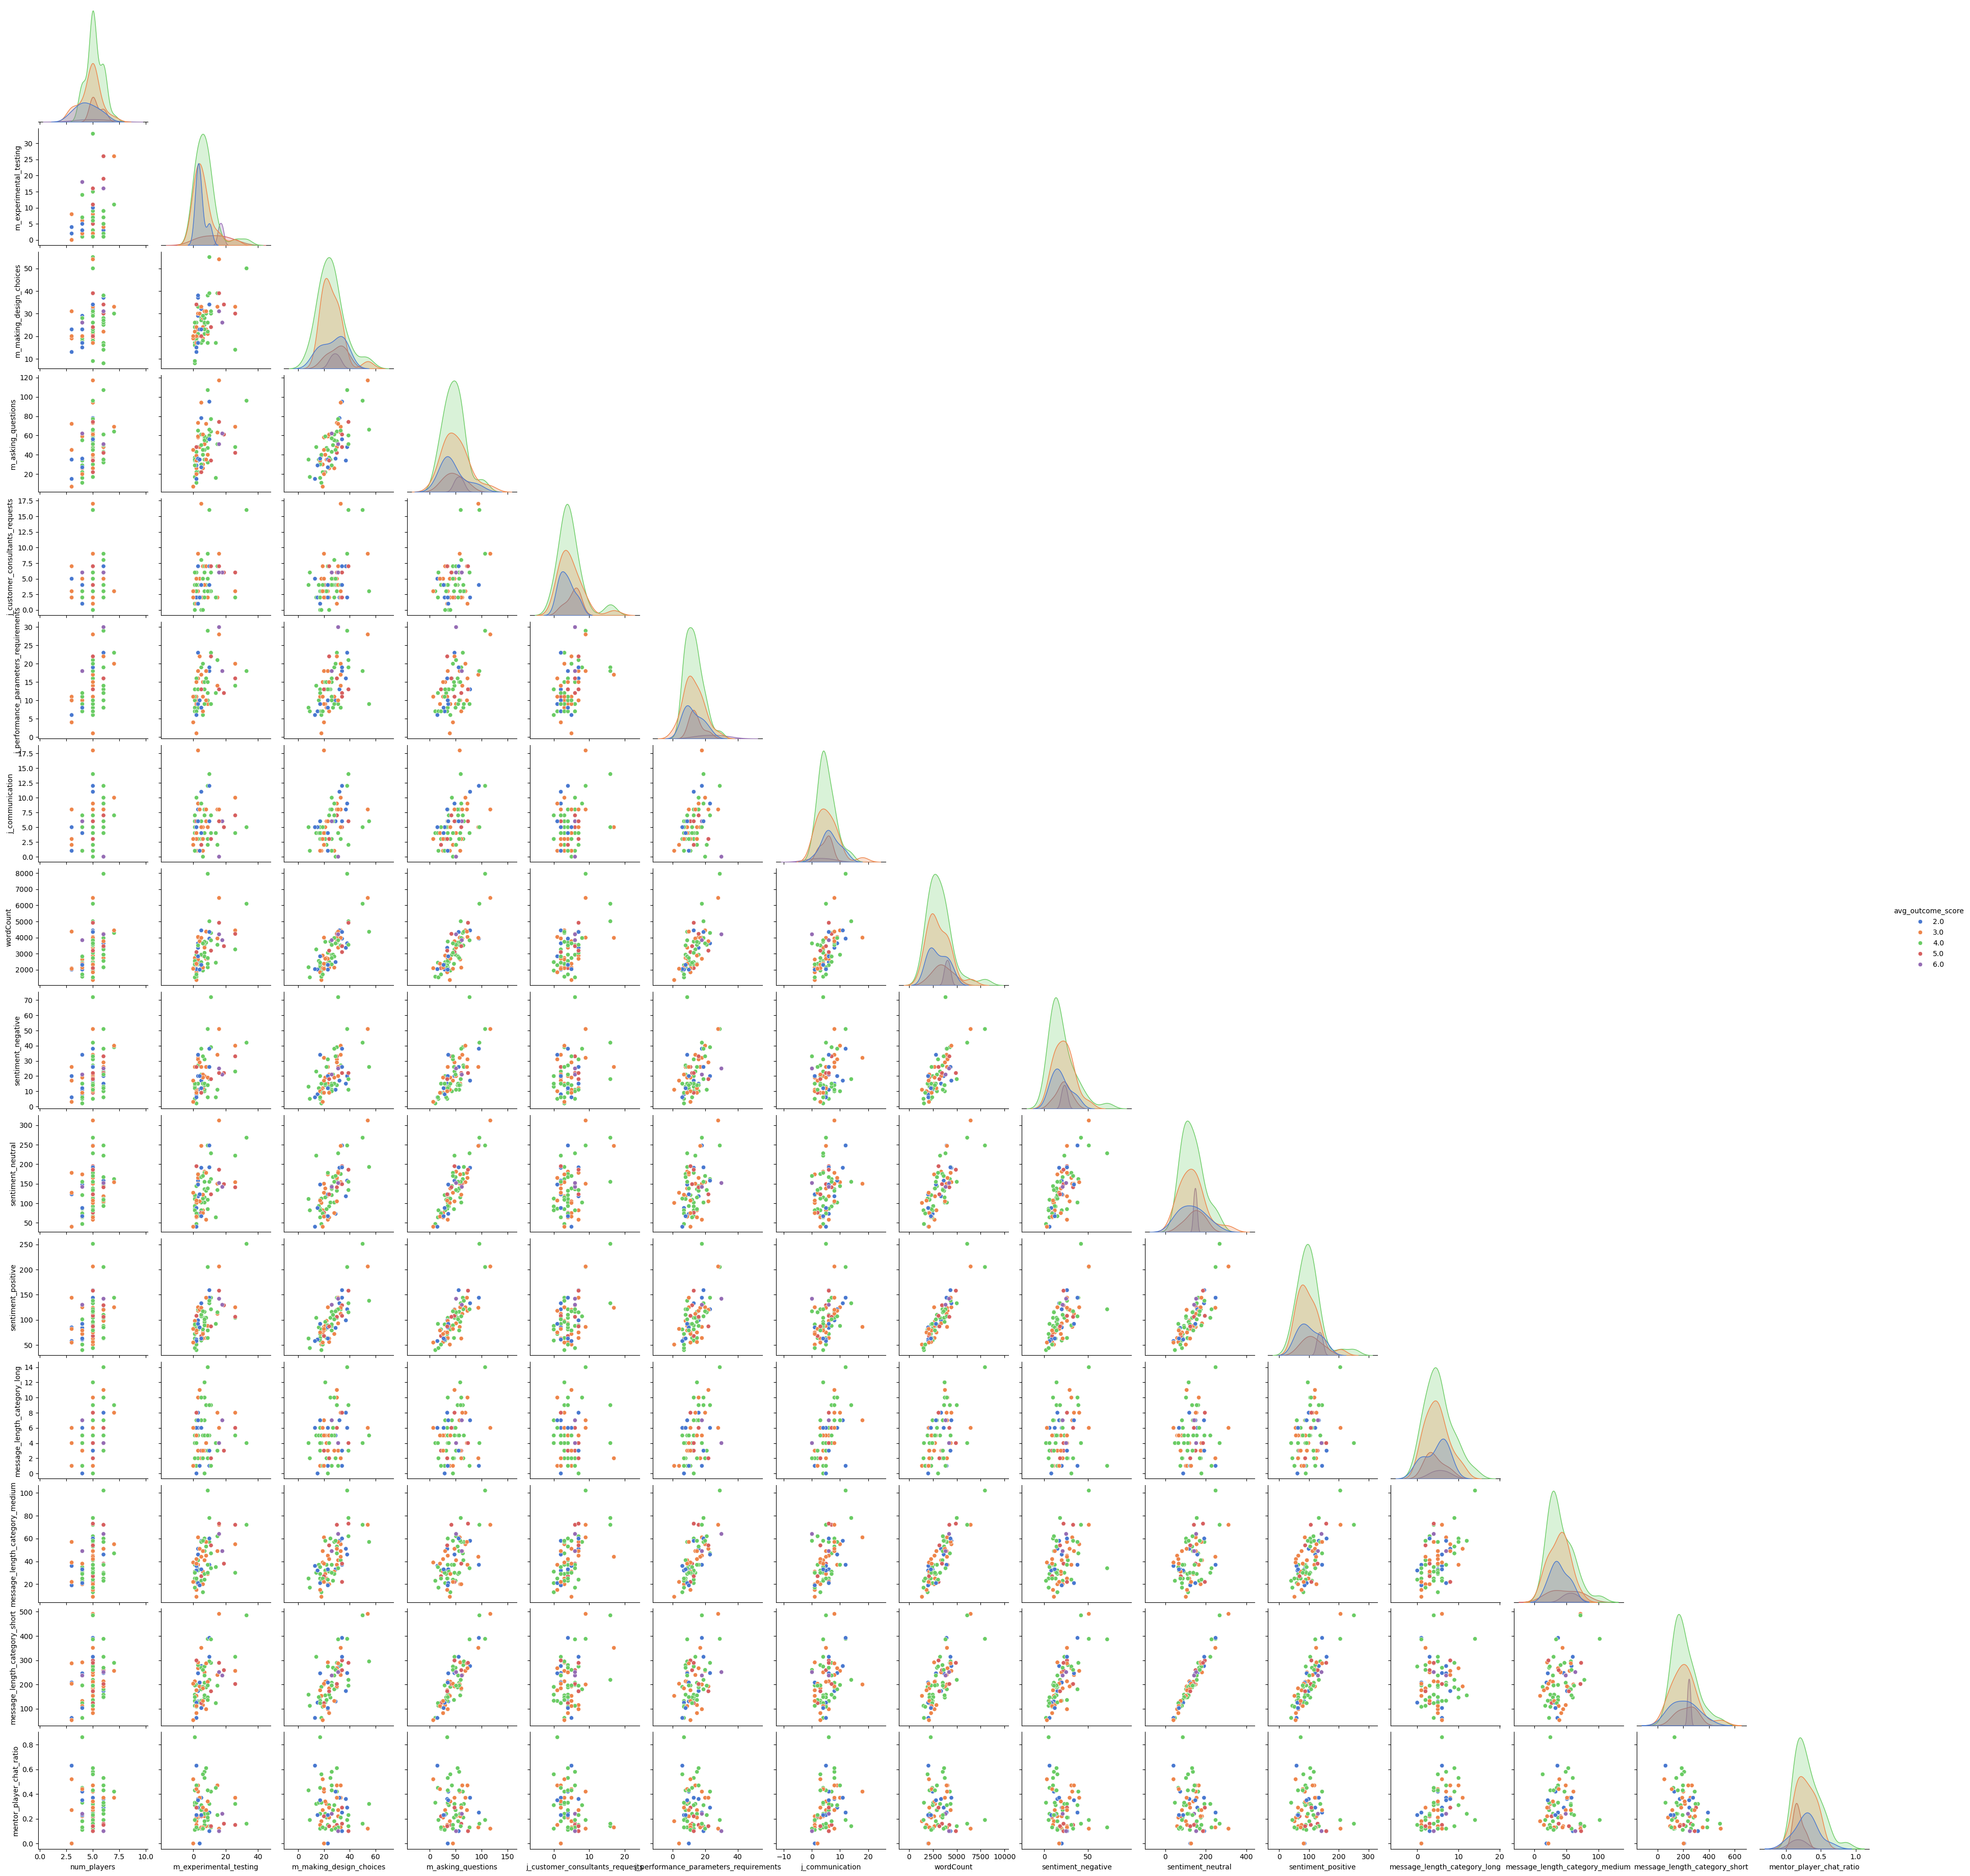

In [144]:
plt.figure(figsize=(100,100))
sns.pairplot(data=vi_team, hue='avg_outcome_score', corner=True, palette='muted');

from the pairplot: no joint pair of features show any clear distinction between average final report marks at team-level.

<hr>

#### Word Cloud

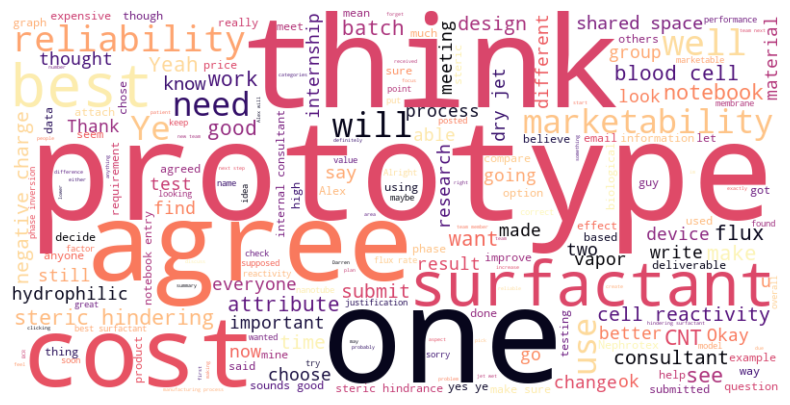

In [22]:


# Combine all text from the 'content' column
text = " ".join(vi["content"].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="magma").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


if you develop code to create new features in the existing dataset, and prove that the new features help with precision of the model 

positive and negative word cloud (code available in ads2001 repository on github)

In [23]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
    

In [24]:
positive_text = ' '.join(vi[vi['sentiment_positive']==1]['clean_text'])
negative_text = ' '.join(vi[vi['sentiment_negative']==1]['clean_text'])

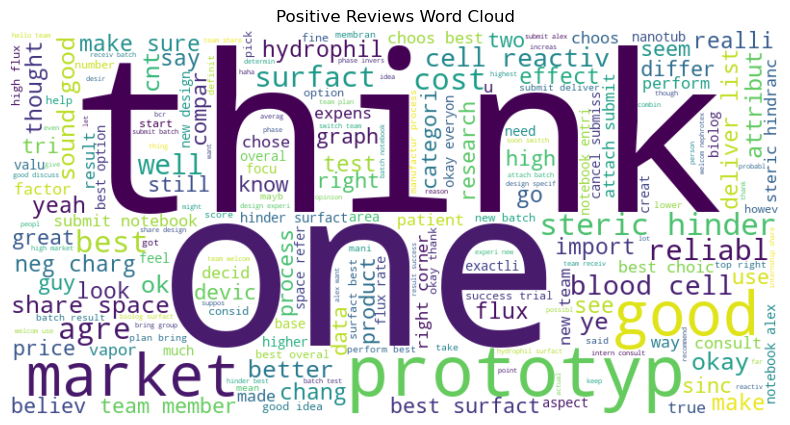

In [25]:
generate_wordcloud(positive_text, 'Positive Reviews Word Cloud')

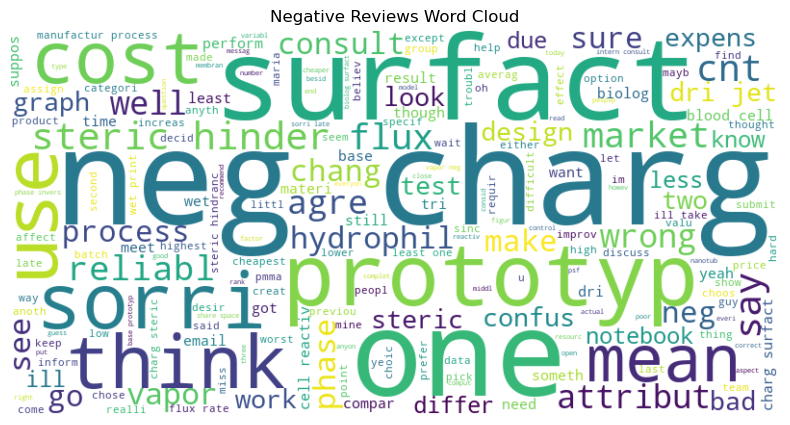

In [26]:
generate_wordcloud(negative_text, 'Negative Reviews Word Cloud')

(updated on 8/04/2025)
since the above word clouds look at the whole chat history, its hard to identify key information

so we will look at the best 5 and worst 5 performing groups in terms of the outcome score.

##### Top 5 best performing groups

In [27]:
vi_team_best = vi_team.sort_values(by='avg_outcome_score',ascending=False)
vi_team_best_5 = vi_team_best.head(5)
vi_team_best_5

num_players implementation ChatGroup  m_experimental_testing  \
74            6              o    PESPVP                    16.0   
68            4              n       PAM                    18.0   
18            6              d       PAM                    19.0   
73            5              o       PAM                    16.0   
72            5              o       PSF                    11.0   

    m_making_design_choices  m_asking_questions  \
74                     31.0                51.0   
68                     26.0                62.0   
18                     34.0                61.0   
73                     39.0                74.0   
72                     24.0                34.0   

    j_customer_consultants_requests  j_performance_parameters_requirements  \
74                              6.0                                   30.0   
68                              6.0                                   18.0   
18                              6.0                                   12.0   
73                              7.0                                   13.0   
72                              7.0                                   22.0   

    j_communication  wordCount  sentiment_negative  sentiment_neutral  \
74              0.0     4199.0                25.0              152.0   
68              6.0     3834.0                21.0              142.0   
18              5.0     3462.0                22.0              149.0   
73              6.0     4913.0                22.0              186.0   
72              3.0     3186.0                18.0              123.0   

    sentiment_positive  message_length_category_long  \
74               142.0                           4.0   
68               130.0                           7.0   
18               129.0                           3.0   
73               158.0                           4.0   
72                87.0                           2.0   

    message_length_category_medium  message_length_category_short  \
74                            64.0                          251.0   
68                            49.0                          237.0   
18                            38.0                          259.0   
73                            73.0                          289.0   
72                            54.0                          172.0   

    avg_outcome_score  mentor_player_chat_ratio  
74                6.0                      0.10  
68                6.0                      0.24  
18                5.0                      0.16  
73                5.0                      0.10  
72                5.0                      0.14

In [28]:
def get_combined_chat(vi, top_teams):
    filtered_rows = []
    for i in range(len(top_teams)):
        implementation = top_teams.iloc[i]['implementation']
        chat_group = top_teams.iloc[i]['ChatGroup']
        filtered = vi[(vi['implementation'] == implementation) & (vi['ChatGroup'] == chat_group)]
        filtered_rows.append(filtered)
    
    combined_df = pd.concat(filtered_rows, ignore_index=True)
    return combined_df

combined_top_members = get_combined_chat(vi, vi_team_best_5)
combined_top_members.head()

userIDs implementation  Line_ID ChatGroup  \
0      367              o    18865    PESPVP   
1      367              o    18866    PESPVP   
2      367              o    18867    PESPVP   
3      367              o    18868    PESPVP   
4      388              o    18869    PESPVP   

                                             content  group_id RoleName  \
0                  Hello team. Welcome to Nephrotex!         6   Mentor   
1  I'm Taylor Sipes. I'll be your design advisor ...         6   Mentor   
2        I'm here to help if you have any questions.         6   Mentor   
3  Please introduce yourselves with the name you ...         6   Mentor   
4                                            Michael         6   Player   

                                            roomName  m_experimental_testing  \
0  Introduction and Workflow Tutorial with Entran...                       0   
1  Introduction and Workflow Tutorial with Entran...                       0   
2  Introduction and Workflow Tutorial with Entran...                       0   
3  Introduction and Workflow Tutorial with Entran...                       0   
4  Introduction and Workflow Tutorial with Entran...                       0   

   m_making_design_choices  ...  wordCount  \
0                        0  ...          5   
1                        0  ...         11   
2                        0  ...          9   
3                        0  ...         51   
4                        0  ...          1   

                                          clean_text  sentiment  \
0                        hello team welcom nephrotex   positive   
1              taylor sipe design advisor internship    neutral   
2                                      help question    neutral   
3  pleas introduc name prefer call workpro record...   positive   
4                                            michael    neutral   

   sentiment_negative  sentiment_neutral  sentiment_positive  \
0                 0.0                0.0                 1.0   
1                 0.0                1.0                 0.0   
2                 0.0                1.0                 0.0   
3                 0.0                0.0                 1.0   
4                 0.0                1.0                 0.0   

  message_length_category message_length_category_long  \
0                   short                          0.0   
1                   short                          0.0   
2                   short                          0.0   
3                    long                          1.0   
4                   short                          0.0   

   message_length_category_medium  message_length_category_short  
0                             0.0                            1.0  
1                             0.0                            1.0  
2                             0.0                            1.0  
3                             0.0                            0.0  
4                             0.0                            1.0  

[5 rows x 25 columns]

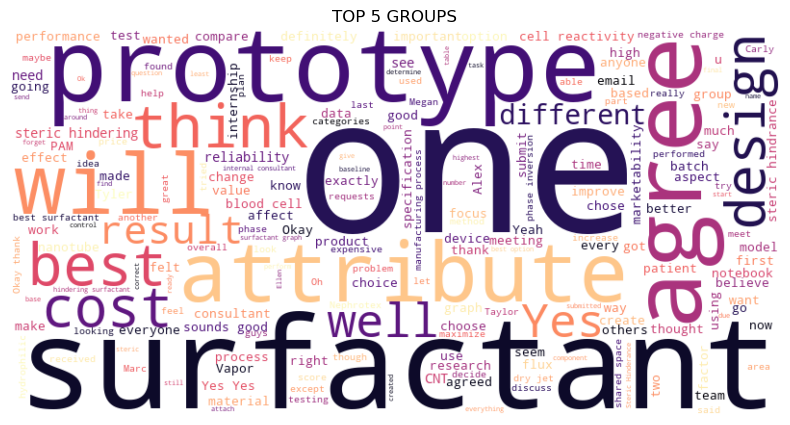

In [29]:
# Combine all text from the 'content' column
text = " ".join(combined_top_members["content"].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="magma").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('TOP 5 GROUPS')
plt.show()

##### Bottom 5 performing groups

In [30]:
vi_team_worst = vi_team.sort_values(by='avg_outcome_score')
vi_team_worst_5 = vi_team_worst.head(5)
vi_team_worst_5

num_players implementation ChatGroup  m_experimental_testing  \
17            5              d       PSF                    10.0   
55            3              l     PRNLT                     2.0   
59            4              l    PESPVP                     3.0   
60            3              m     PRNLT                     4.0   
11            5              c      PMMA                     5.0   

    m_making_design_choices  m_asking_questions  \
17                     34.0                95.0   
55                     13.0                15.0   
59                     17.0                36.0   
60                     23.0                35.0   
11                     32.0                78.0   

    j_customer_consultants_requests  j_performance_parameters_requirements  \
17                              4.0                                   18.0   
55                              5.0                                    6.0   
59                              1.0                                    9.0   
60                              2.0                                   10.0   
11                              2.0                                   13.0   

    j_communication  wordCount  sentiment_negative  sentiment_neutral  \
17             12.0     3931.0                38.0              248.0   
55              5.0     2037.0                 6.0               40.0   
59              6.0     2832.0                34.0              148.0   
60              1.0     2005.0                20.0              123.0   
11             11.0     4440.0                17.0              190.0   

    sentiment_positive  message_length_category_long  \
17               144.0                           1.0   
55                58.0                           6.0   
59                92.0                           7.0   
60                85.0                           1.0   
11               134.0                           7.0   

    message_length_category_medium  message_length_category_short  \
17                            37.0                          392.0   
55                            36.0                           62.0   
59                            21.0                          246.0   
60                            19.0                          208.0   
11                            58.0                          276.0   

    avg_outcome_score  mentor_player_chat_ratio  
17                2.0                      0.25  
55                2.0                      0.63  
59                2.0                      0.35  
60                2.0                      0.00  
11                2.0                      0.37

In [31]:
combined_bottom_members = get_combined_chat(vi, vi_team_worst_5)
combined_bottom_members.head()

userIDs implementation  Line_ID ChatGroup  \
0       90              d     5025       PSF   
1       90              d     5026       PSF   
2       90              d     5027       PSF   
3      101              d     5028       PSF   
4       90              d     5029       PSF   

                                             content  group_id RoleName  \
0                  Hello team. Welcome to Nephrotex!         4   Mentor   
1  I'm Nassim Tehrani. I'll be your design adviso...         4   Mentor   
2        I'm here to help if you have any questions.         4   Mentor   
3                        so what we need to do first         4   Player   
4   If you haven't already, please check your email.         4   Mentor   

                                            roomName  m_experimental_testing  \
0  Introduction and Workflow Tutorial with Entran...                       0   
1  Introduction and Workflow Tutorial with Entran...                       0   
2  Introduction and Workflow Tutorial with Entran...                       0   
3  Introduction and Workflow Tutorial with Entran...                       0   
4  Introduction and Workflow Tutorial with Entran...                       0   

   m_making_design_choices  ...  wordCount  \
0                        0  ...          5   
1                        0  ...         11   
2                        0  ...          9   
3                        0  ...          7   
4                        0  ...          8   

                                 clean_text  sentiment  sentiment_negative  \
0               hello team welcom nephrotex   positive                 0.0   
1  nassim tehrani design advisor internship    neutral                 0.0   
2                             help question    neutral                 0.0   
3                                need first   positive                 0.0   
4                 alreadi pleas check email    neutral                 0.0   

   sentiment_neutral  sentiment_positive message_length_category  \
0                0.0                 1.0                   short   
1                1.0                 0.0                   short   
2                1.0                 0.0                   short   
3                0.0                 1.0                   short   
4                1.0                 0.0                   short   

  message_length_category_long  message_length_category_medium  \
0                          0.0                             0.0   
1                          0.0                             0.0   
2                          0.0                             0.0   
3                          0.0                             0.0   
4                          0.0                             0.0   

   message_length_category_short  
0                            1.0  
1                            1.0  
2                            1.0  
3                            1.0  
4                            1.0  

[5 rows x 25 columns]

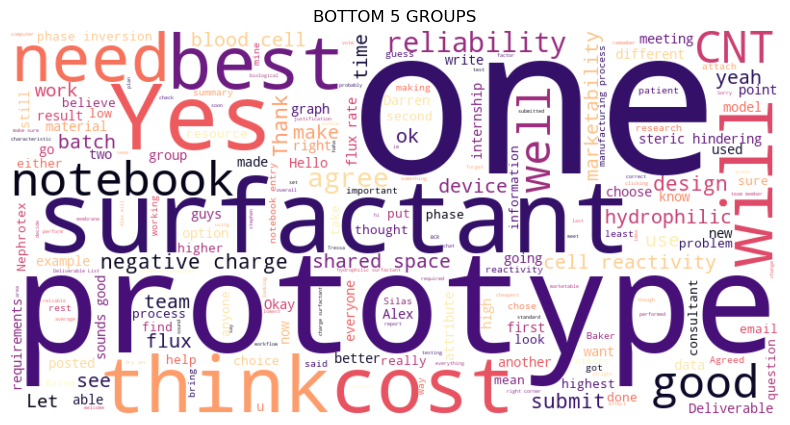

In [32]:
# Combine all text from the 'content' column
text = " ".join(combined_bottom_members["content"].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="magma").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('BOTTOM 5 GROUPS')
plt.show()

key observations:
- top groups are using words like 'cost', 'result', 'attribute' which could mean they are doing more discussions and thinking about what would be the best thing to do
- the bottom groups are just saying 'yes' to what is in the chat (?) and not using words that could lead to discussion

#### (maybe include) LDA topic modelling

basically looks at large text data and identify commonly used words and groups them into topics

In [33]:
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(vi['clean_text'])

the code below takes a while to run!

In [34]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [35]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

display_topics(lda_model, vectorizer.get_feature_names_out(), 10)

Topic 1:
reliabl | cost | flux | reactiv | cnt | consult | market | blood | cell | vapor

Topic 2:
agre | surfact | best | prototyp | think | differ | attribut | perform | design | use

Topic 3:
steric | notebook | hinder | neg | charg | submit | make | market | surfact | sure

Topic 4:
ye | team | batch | yeah | ok | guy | design | attach | prototyp | group

Topic 5:
good | time | thank | meet | okay | everyon | alex | sound | email | share



##### Key observations from LDA model



###### Topic 1:

This topic reflects conversations focused on product reliability, market consultation and scientific terms


###### Topic 2:

This topic highlights teamwork and decision-making around design, prototypes and performance characteristics, suggesting the interns were having productive discussions


###### Topic 3:

could be talking about task submissions


###### Topic 4:

reflects informal team coordination or casual project updates between group members


###### Topic 5:

likely covers routine communication like scheduling, expressing gratitude and collaboration updates.

(suggestion, do this for top and bottom performing groups so we know what topics they were talking about and how that could influence their respective outcome score)

#### Doing LDA model for top best and worst performing groups

(updated on 9/04/2025)

##### BEST 5

In [36]:
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(combined_top_members['clean_text'])

lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

display_topics(lda_model, vectorizer.get_feature_names_out(), 10)

Topic 1:
attribut | surfact | best | devic | consult | hinder | tri | steric | choos | design

Topic 2:
agre | prototyp | steric | think | cnt | best | like | reliabl | cost | use

Topic 3:
ye | good | notebook | submit | everyon | batch | sound | need | think | prototyp

Topic 4:
surfact | use | categori | graph | best | differ | rate | design | aspect | perform

Topic 5:
thank | team | okay | time | work | meet | help | group | new | design



General Observations:

- Frequent use of technical and evaluative language such as attributes, device, consult, prototype, reliable, design, and performance.
- Collaboration is present: team, thank, help, group.
- There's also technical decision-making language: choose, cost, use, rate, aspect

Topic Insights:


Topic 1:
Focused on product characteristics and performance evaluation. Suggests thoughtful technical analysis and collaboration.

Topic 2:
Indicates idea refinement and prototyping discussions, as well as weighing trade-offs like cost and reliability.

Topic 3:
Combination of task coordination with brainstorming and critical input.

Topic 4:
Analytical thinking reflected through words like "graph", "rate", "aspect", and "performance".

Topic 5:
Emphasizes strong teamwork, organization, and mutual support — essential traits of high-performing teams.



##### WORST 5

In [37]:
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(combined_bottom_members['clean_text'])

lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

display_topics(lda_model, vectorizer.get_feature_names_out(), 10)

Topic 1:
design | team | batch | work | new | need | submit | attach | specif | make

Topic 2:
thank | share | space | make | need | okay | let | consult | everyon | meet

Topic 3:
prototyp | agre | notebook | devic | hello | use | surfact | good | yeah | tri

Topic 4:
surfact | ye | cost | best | cnt | reliabl | good | flux | reactiv | neg

Topic 5:
ok | deliver | right | submit | list | notebook | alex | click | internship | guy



General Observations:

- More task-level language, less technical or evaluative language.
- "submit", "ok", "list", and casual phrasing.
- Slightly more passive — less sign of technical analysis or critical design thinking.

Topic Insights:

Topic 1:
Focus on task execution and group activity, but lacks deeper evaluative or design-focused language.

Topic 2:
Casual and cooperative tone, centered around coordination, not analysis.

Topic 3:
Attempts at technical discussion are present but diluted by informal or off-topic language.

Topic 4:
Some technical focus here; however, may reflect only pockets of deeper discussion.

Topic 5:
Reflects basic task-related or logistical communication with minimal analytical content.

<hr style="color: #6f8f7e; border: 2px solid;">

### Predictive Modelling

train test split

In [38]:
# Define the features (X) and the target variable (y)
X = vi_team.drop(columns=['avg_outcome_score', 'implementation', 'ChatGroup'])  
y = vi_team['avg_outcome_score']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Baseline models

**Categorical data approach**

- because the average outcome score only varies between **intergers** of 0-8, treating the **target variable** as categorical data is a better approach.

In [39]:
# 1. Split again to stratify
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Rescale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Logsitic Regression, KNN, Decision Tree, Random Forest and HistGradientBoosting**

In [40]:

# 4. Initialize Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42)
    # "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# 5. Train Models, Predict, and Evaluate
results = []
team_predictions = {}

for name, model in models.items():
    if name in ["Logistic Regression", "KNN"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Model: {name}")
    print("Accuracy:", acc)
    print("Macro F1 Score:", f1)
    print(classification_report(y_test, y_pred))
    print("="*50)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Macro F1': f1
    })

    # Save team-level predictions
    team_predictions[name] = y_pred

# 6. Results Summary
results_df = pd.DataFrame(results)
print("\nSummary of Model Performances:")
print(results_df)

# 7. Predicted scores for each team (example for Random Forest)
print("\nPredicted Scores by Random Forest:")
print(team_predictions["Random Forest"])

# Optional: Create a DataFrame for team predictions
team_pred_df = pd.DataFrame({
    'Team_Index': np.arange(len(y_test)),
    'Average individual score': y_test,
    'Predicted_Score_RF': team_predictions["Random Forest"],
    'Predicted_Score_HistBoost' : team_predictions["HistGradientBoosting"]
    
})

print("\nTeam Predictions:")
print(team_pred_df)

Model: Logistic Regression
Accuracy: 0.2
Macro F1 Score: 0.07999999999999999
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         4
         4.0       0.38      0.43      0.40         7
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         1

    accuracy                           0.20        15
   macro avg       0.07      0.09      0.08        15
weighted avg       0.17      0.20      0.19        15

Model: Decision Tree
Accuracy: 0.3333333333333333
Macro F1 Score: 0.14666666666666667
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         2
         3.0       0.17      0.25      0.20         4
         4.0       0.50      0.57      0.53         7
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         1

    accuracy          

- to check the `training score` and `testing score`

In [41]:

results = []
team_predictions = {}

for name, model in models.items():
    # Fit on scaled or unscaled data
    if name in ["Logistic Regression", "KNN"]:
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

    # Training scores
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')

    # Testing scores
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')

    print(f"Model: {name}")
    print(f"Train Accuracy: {train_acc:.3f}, Train Macro F1: {train_f1:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}, Test Macro F1: {test_f1:.3f}")
    # print(classification_report(y_test, y_test_pred))
    print("="*50)

    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Train Macro F1': train_f1,
        'Test Accuracy': test_acc,
        'Test Macro F1': test_f1
    })

    # Save team-level predictions
    team_predictions[name] = y_test_pred

# 6. Results Summary
results_df = pd.DataFrame(results)
print("\nSummary of Model Performances:")
results_df

# # 7. Predicted scores for each team (example for Random Forest)
# print("\nPredicted Scores by Random Forest:")
# print(team_predictions["Random Forest"])


# team_pred_df_tts = pd.DataFrame({
#     'Team_Index': np.arange(len(y_test)),
#     'Average individual score': y_test,
#     'Predicted_Score_RF': team_predictions["Random Forest"],
#     'Predicted_Score_HistBoost': team_predictions["HistGradientBoosting"]
# })

# print("\nTeam Predictions:")
# print(team_pred_df_tts)


Model: Logistic Regression
Train Accuracy: 0.583, Train Macro F1: 0.441
Test Accuracy: 0.200, Test Macro F1: 0.080
Model: Decision Tree
Train Accuracy: 1.000, Train Macro F1: 1.000
Test Accuracy: 0.333, Test Macro F1: 0.147
Model: KNN
Train Accuracy: 0.517, Train Macro F1: 0.407
Test Accuracy: 0.133, Test Macro F1: 0.062
Model: Random Forest
Train Accuracy: 1.000, Train Macro F1: 1.000
Test Accuracy: 0.267, Test Macro F1: 0.089
Model: HistGradientBoosting
Train Accuracy: 0.867, Train Macro F1: 0.909
Test Accuracy: 0.200, Test Macro F1: 0.067

Summary of Model Performances:


Model  Train Accuracy  Train Macro F1  Test Accuracy  \
0   Logistic Regression        0.583333        0.440857       0.200000   
1         Decision Tree        1.000000        1.000000       0.333333   
2                   KNN        0.516667        0.406869       0.133333   
3         Random Forest        1.000000        1.000000       0.266667   
4  HistGradientBoosting        0.866667        0.908847       0.200000   

   Test Macro F1  
0       0.080000  
1       0.146667  
2       0.061538  
3       0.088889  
4       0.066667

**AdaBoosting**

In [42]:
vi_ada = AdaBoostRegressor(
    estimator=RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=13), 
    n_estimators=200, random_state=13
)
vi_ada.fit(X_train, y_train)

# Predict
y_pred_train_ada = vi_ada.predict(X_train)
y_pred_test_ada = vi_ada.predict(X_test)


# Round predictions
y_pred_ada_test_rounded = np.round(y_pred_test_ada)
y_pred_ada_train_rounded = np.round(y_pred_train_ada)


# Training scores
train_acc_ada = accuracy_score(y_train, y_pred_ada_train_rounded)
train_f1_ada = f1_score(y_train, y_pred_ada_train_rounded, average='macro')

# Testing scores
test_acc_ada = accuracy_score(y_test, y_pred_ada_test_rounded)
test_f1_ada = f1_score(y_test, y_pred_ada_test_rounded, average='macro')



# print("Accuracy after rounding:", test_acc_ada)
# print("Macro F1 Score after rounding:", test_f1_ada)


print(f"Classfication report for train")
print(classification_report(y_train, y_pred_ada_train_rounded))
print(f"Train Accuracy: {train_acc_ada:.3f}, Train Macro F1: {train_f1_ada:.3f}")
print("="*50)

print(f"Classfication report for test")
print(classification_report(y_test, y_pred_ada_test_rounded))
print(f"Test Accuracy: {test_acc_ada:.3f}, Test Macro F1: {test_f1_ada:.3f}")
print("="*50)




Classfication report for train
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         9
         3.0       1.00      1.00      1.00        18
         4.0       1.00      1.00      1.00        27
         5.0       1.00      1.00      1.00         5
         6.0       1.00      1.00      1.00         1

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Train Accuracy: 1.000, Train Macro F1: 1.000
Classfication report for test
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         2
         3.0       0.17      0.25      0.20         4
         4.0       0.44      0.57      0.50         7
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         1

    accuracy                           0.33        15
   macro avg       0.12  

- `training score` and `testing score` for Ada Boost

In [43]:
pd.DataFrame({
    'accuracy': [train_acc_ada, round(test_acc_ada,3)],
    'f1': [train_f1_ada, round(test_f1_ada,3)]
}, index=['train', 'test'])


accuracy    f1
train     1.000  1.00
test      0.333  0.14

<hr>

##### Features importance from classifier


Feature Importances (Random Forest):
                                  Feature  Importance
13          message_length_category_short    0.095788
2                 m_making_design_choices    0.082549
14               mentor_player_chat_ratio    0.078732
12         message_length_category_medium    0.077514
7                               wordCount    0.076962
5   j_performance_parameters_requirements    0.076424
1                  m_experimental_testing    0.071550
10                     sentiment_positive    0.063761
8                      sentiment_negative    0.062746
9                       sentiment_neutral    0.062642
11           message_length_category_long    0.059796
3                      m_asking_questions    0.057887
6                         j_communication    0.046495
4         j_customer_consultants_requests    0.044638
0                             num_players    0.042516


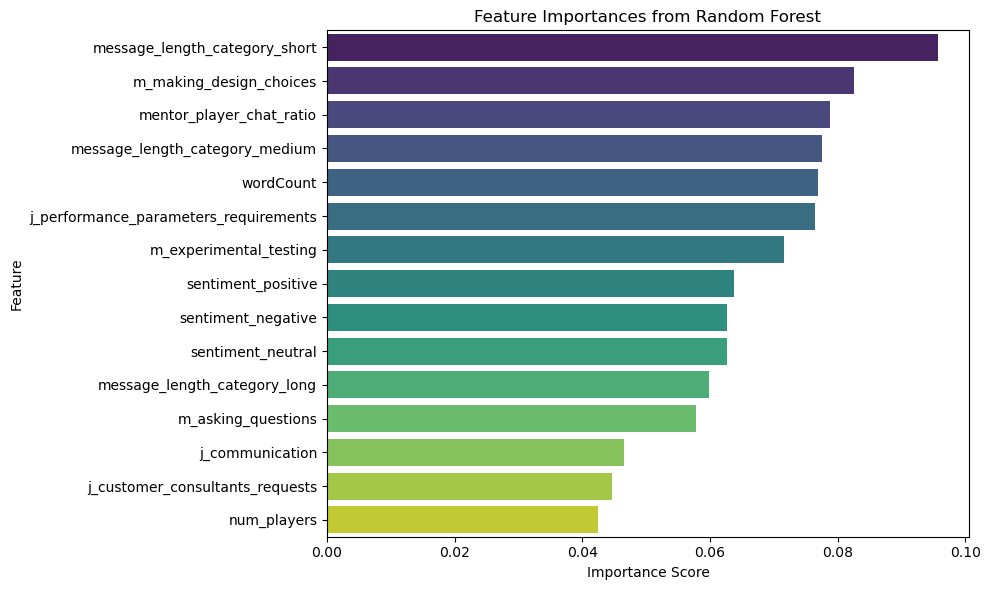

In [44]:
# Feature Importance from Random Forest
rf_model = models["Random Forest"]  

importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display
print("\nFeature Importances (Random Forest):")
print(feat_importance_df)

# Plot importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


<hr>

##### More meaningful NLP

*this part should be included in the `data engineering` section of the final report, I placed it here because I realised the features engineering is still **not sufficient** after I performed `features importance` which requires `train_test_split` and **modelling** using `Random Forest` .*

<br>

- after reviewing the features importance, the importance of each features are almost equal because **1/15 features = 0.06667**, where the highest feature importance is only **0.094266**, indicating it is just slightly important (around 1.41% higher) than the shared equal importance.
- I decided to extract more meaninful features especially from the `content` column

**1. SVD (Singular Value Decomposition)**
- reduce dimensionality by compressing the 1000-dimensional TF-IDF vectors into 50 dimensions while preserving the most important patterns.
- This is the `semantic compression` where the 50 latent features often capture broader topics or themes in the text.
- 50 more columns (features) is created in the `vi` dataset (it will be aggregated when converting to team level statistics in `vi_team`).

In [45]:

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(vi['clean_text'])

svd = TruncatedSVD(n_components=50, random_state=42)
svd_tfidf = svd.fit_transform(tfidf)
svd_df = pd.DataFrame(svd_tfidf, columns=[f'svd_{i}' for i in range(svd_tfidf.shape[1])])
vi = pd.concat([vi, svd_df], axis=1)

**2. Lexical diversity, character count, and word count**

- `lexical_diversity` function is to measure **richness of vocabulary (unique words)** in the chat.
  - if close to 1, then it has high diversity, and if its close to 0 then it has low diversity
- **character count** counts the total number of **character** in chat.
- **word_count** counts the total number of **words** in chat.


In [46]:
def lexical_diversity(text):
    tokens = word_tokenize(text.lower())
    words = [word for word in tokens if word.isalpha()]
    return len(set(words)) / len(words) if words else 0

vi['lexical_diversity'] = vi['clean_text'].apply(lexical_diversity)
vi['char_count'] = vi['content'].apply(len)
vi['word_count'] = vi['content'].apply(lambda x: len(x.split()))
vi['avg_word_length'] = vi['content'].apply(
    lambda x: np.mean([len(w) for w in x.split() if w.isalpha()]) if len(x.split()) > 0 else 0
)

**3. LDA**
- use `LatentDirichletAllocation` (LDA) to find the 5 distinct important topic
- train the LDA model on the Bag-of-Words matrix and outputs a document-topic matrix
- Each column `topic_0` to `topic_4` contains the probability that the message belongs to that topic.

In [47]:
# Fit LDA on the cleaned content
lda_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
lda_bow = lda_vectorizer.fit_transform(vi['clean_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(lda_bow)

# Add topic distributions back to original DataFrame
lda_topic_df = pd.DataFrame(lda_topics, columns=[f'topic_{i}' for i in range(5)])
vi = pd.concat([vi.reset_index(drop=True), lda_topic_df.reset_index(drop=True)], axis=1)

**4. Topic Coherence Score**

- `topic_coherence` function calculates two metrics to evaluate **semantic coherence**
  - Average Entropy (measures topic spread/diversity)
      - High entropy means topic is diverse and vice versa
  - Average Cosine Similarity (measures topic alignment/coherence)
      - High cosine similarity means team members discuss similar topics and vice versa

In [48]:
def topic_coherence(team_topic_vectors):
    # Entropy: measures topic spread
    entropies = [entropy(vec) for vec in team_topic_vectors]
    avg_entropy = np.mean(entropies)

    # Cosine similarity: coherence between team members
    sim_matrix = cosine_similarity(team_topic_vectors)
    avg_cosine_sim = np.mean(sim_matrix[np.triu_indices_from(sim_matrix, k=1)])

    return avg_entropy, avg_cosine_sim


**5. Sentiment consistency**

- using metrics like **standard deviation** to calculate sentiment consistency

In [49]:
def sentiment_consistency(sentiment_scores):
    return np.std(sentiment_scores)  

- update the **team-level statistics** code again

Aggregate the new featurs on `team level statistics` first

In [50]:
text_feats = ['lexical_diversity', 'char_count', 'word_count', 'avg_word_length']
team_text_stats = (
    vi.groupby(['implementation', 'ChatGroup'])[text_feats]
    .mean()
    .reset_index()
    .rename(columns={
        'lexical_diversity': 'team_lexical_diversity',
        'char_count': 'team_char_count',
        'word_count': 'team_word_count',
        'avg_word_length': 'team_avg_word_length'
    })
)

Recompute `get_team_stats` function

In [51]:
def get_team_stats(vi, intake, group):
    team = vi.loc[(vi['implementation'] == intake) & (vi['ChatGroup'] == group)]
    team_stats = []

    num_players = len(team['userIDs'].unique()) - 1
    team_stats += [num_players, intake, group]

    vi_disc_features = [
        'm_experimental_testing', 'm_making_design_choices', 'm_asking_questions',
        'j_customer_consultants_requests', 'j_performance_parameters_requirements', 'j_communication',
        'wordCount', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
        'message_length_category_long', 'message_length_category_medium', 'message_length_category_short'
    ]

    team_stats += team[vi_disc_features].sum().tolist()

    team_stats += [((team[team.RoleName != 'Mentor'])[['userIDs', 'OutcomeScore']].drop_duplicates('userIDs'))['OutcomeScore'].mean().round(0)]

    mentor_wc = team[team.RoleName == 'Mentor'][['userIDs', 'wordCount']].groupby('userIDs').sum()['wordCount'].sum()
    player_wc = team[team.RoleName != 'Mentor'][['userIDs', 'wordCount']].groupby('userIDs').sum()['wordCount'].sum()
    team_stats += [round(mentor_wc / player_wc, 2) if player_wc != 0 else 0]

    topic_cols = [f'topic_{i}' for i in range(5)]


    # Team-level behavioral indicators
    topic_coherence = team[topic_cols].std().mean()
    sentiment_cols = ['sentiment_negative', 'sentiment_neutral', 'sentiment_positive']
    sentiment_consistency = team[sentiment_cols].std().mean()

    team_stats += [topic_coherence, sentiment_consistency]
    team_stats += team[topic_cols].mean().tolist()

    return team_stats

# --- Generate team-level dataset ---
vi_team_columns = [
    'num_players', 'implementation', 'ChatGroup',
    'm_experimental_testing', 'm_making_design_choices', 'm_asking_questions',
    'j_customer_consultants_requests', 'j_performance_parameters_requirements', 'j_communication',
    'wordCount', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
    'message_length_category_long', 'message_length_category_medium', 'message_length_category_short',
    'avg_outcome_score', 'mentor_player_chat_ratio',
    'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4','topic_coherence', 'sentiment_consistency'
]

# Populate vi_team
implementations = vi['implementation'].unique().tolist()
groups = vi['ChatGroup'].unique().tolist()
for i in implementations:
    for g in groups:
        # vi_team = pd.concat([vi_team, pd.DataFrame([get_team_stats(vi, i, g)], columns=vi_team.columns)], ignore_index=True)
        vi_team = pd.concat([vi_team, pd.DataFrame([get_team_stats(vi, i, g)])], ignore_index=True)


vi_team['num_players'] = pd.to_numeric(vi_team['num_players'])
vi_team = pd.DataFrame(columns=vi_team_columns)



implementations = vi['implementation'].unique().tolist()
groups = vi['ChatGroup'].unique().tolist()

for i in implementations:
    for g in groups:
        vi_team = pd.concat([vi_team, pd.DataFrame([get_team_stats(vi, i, g)], columns=vi_team_columns)], ignore_index=True)

vi_team['num_players'] = pd.to_numeric(vi_team['num_players'])
vi_team = pd.merge(vi_team, team_text_stats, on=['implementation', 'ChatGroup'], how='left')



In [52]:
vi_team.groupby('avg_outcome_score').size()

avg_outcome_score
2.0    11
3.0    22
4.0    34
5.0     6
6.0     2
dtype: int64

**Total of 75 rows(samples/teams) and 29 columns(features)**

- Recompute `features importance`

In [53]:
# train test split again
X = vi_team.drop(columns=['avg_outcome_score', 'implementation', 'ChatGroup'])  
y = vi_team['avg_outcome_score']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



ALL Feature Importances (Random Forest):
                                  Feature  Importance
17                                topic_2    0.060955
21                  sentiment_consistency    0.060837
18                                topic_3    0.059189
22                 team_lexical_diversity    0.053545
1                  m_experimental_testing    0.049131
19                                topic_4    0.048647
15                                topic_0    0.044599
16                                topic_1    0.043541
20                        topic_coherence    0.043480
2                 m_making_design_choices    0.042223
12         message_length_category_medium    0.042145
14               mentor_player_chat_ratio    0.038996
8                      sentiment_negative    0.038122
25                   team_avg_word_length    0.034345
24                        team_word_count    0.033594
7                               wordCount    0.033492
11           message_length_category_lon

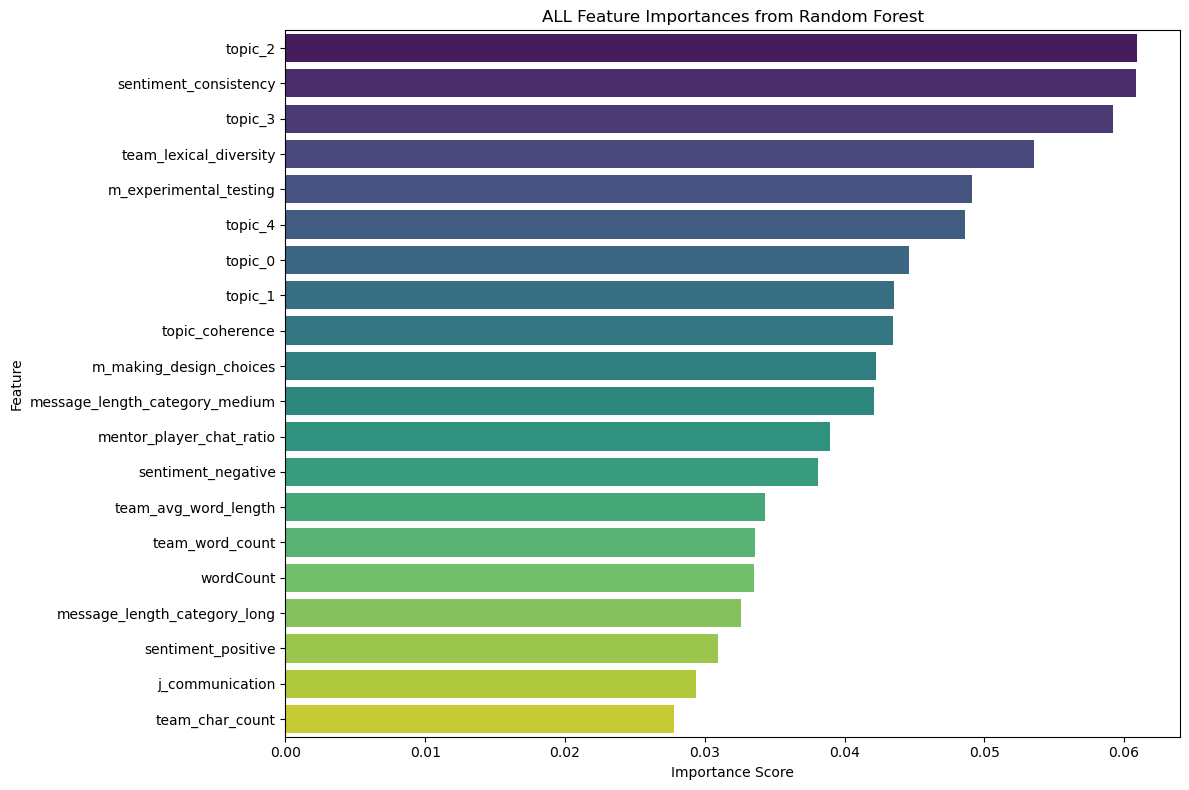

In [54]:
# Fit a fresh model again
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Put into DataFrame
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display ALL features importance
print("\nALL Feature Importances (Random Forest):")
print(feat_importance_df)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=feat_importance_df.head(20),
    x='Importance', y='Feature',
    palette='viridis'
)
plt.title('ALL Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


<hr>

- Shared importance of all 24 features is **1/26 = 0.03846**
- This means if the importance feature is above **0.03846** (the average), then it is considered **important**
- These features are : `sentiment_consistency`,`topic_2`, `topic_3`, `m_experimental_testing`,`team_lexical_diversity`,
    `topic_4`,`topic_1`,`topic_0`,`topic_coherence`,`message_length_category_medium` and `m_making_design_choices`

**Now, retrain the model with the these features.**

#### Refined models 

In [61]:
# train test split again
X = vi_team[['sentiment_consistency','topic_2', 'topic_3', 'm_experimental_testing','team_lexical_diversity',
             'topic_4','topic_1','topic_0','topic_coherence','message_length_category_medium', 'm_making_design_choices']]
y = vi_team['avg_outcome_score']   


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




##### Refined `Logstic Regression`, `KNN`, `Decision Tree`, `Random Forest` and `HistGradientBoosting` model

In [62]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42)
    # "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# 5. Train Models, Predict, and Evaluate
results = []
team_predictions = {}

for name, model in models.items():
    if name in ["Logistic Regression", "KNN"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Model: {name}")
    print("Accuracy:", acc)
    print("Macro F1 Score:", f1)
    print(classification_report(y_test, y_pred))
    print("="*50)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Macro F1': f1
    })

    # Save team-level predictions
    team_predictions[name] = y_pred

# 6. Results Summary
results_df = pd.DataFrame(results)
print("\nSummary of Model Performances:")
print(results_df)

# 7. Predicted scores for each team (example for Random Forest)
print("\nPredicted Scores by Random Forest:")
print(team_predictions["Random Forest"])



Model: Logistic Regression
Accuracy: 0.4666666666666667
Macro F1 Score: 0.18421052631578946
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         4
         4.0       0.64      0.88      0.74         8
         5.0       0.00      0.00      0.00         1

    accuracy                           0.47        15
   macro avg       0.16      0.22      0.18        15
weighted avg       0.34      0.47      0.39        15

Model: Decision Tree
Accuracy: 0.26666666666666666
Macro F1 Score: 0.17142857142857143
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         2
         3.0       0.33      0.50      0.40         4
         4.0       0.33      0.25      0.29         8
         5.0       0.00      0.00      0.00         1

    accuracy                           0.27        15
   macro avg       0.17      0.19      0.17        15
weight

check training and testing score

In [63]:
results = []
team_predictions = {}

for name, model in models.items():
    # Fit on scaled or unscaled data
    if name in ["Logistic Regression", "KNN"]:
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

    # Training scores
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')

    # Testing scores
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')

    print(f"Model: {name}")
    print(f"Train Accuracy: {train_acc:.3f}, Train Macro F1: {train_f1:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}, Test Macro F1: {test_f1:.3f}")
    # print(classification_report(y_test, y_test_pred))
    print("="*50)

    results.append({
        'Model': name,
        'Train Accuracy': round(train_acc,3),
        'Test Accuracy': round(test_acc,3),
        'Train Macro F1': round(train_f1,3),
        'Test Macro F1': round(test_f1,3)
    })

    # Save team-level predictions
    team_predictions[name] = y_test_pred

# 6. Results Summary
results_df = pd.DataFrame(results)
print("\nSummary of Model Performances:")
results_df

# # 7. Predicted scores for each team (example for Random Forest)
# print("\nPredicted Scores by Random Forest:")
# print(team_predictions["Random Forest"])


# team_pred_df_tts = pd.DataFrame({
#     'Team_Index': np.arange(len(y_test)),
#     'Average individual score': y_test,
#     'Predicted_Score_RF': team_predictions["Random Forest"],
#     'Predicted_Score_HistBoost': team_predictions["HistGradientBoosting"]
# })

# print("\nTeam Predictions:")
# print(team_pred_df_tts)


Model: Logistic Regression
Train Accuracy: 0.517, Train Macro F1: 0.360
Test Accuracy: 0.467, Test Macro F1: 0.184
Model: Decision Tree
Train Accuracy: 1.000, Train Macro F1: 1.000
Test Accuracy: 0.267, Test Macro F1: 0.171
Model: KNN
Train Accuracy: 0.533, Train Macro F1: 0.383
Test Accuracy: 0.333, Test Macro F1: 0.156
Model: Random Forest
Train Accuracy: 1.000, Train Macro F1: 1.000
Test Accuracy: 0.400, Test Macro F1: 0.210
Model: HistGradientBoosting
Train Accuracy: 0.867, Train Macro F1: 0.911
Test Accuracy: 0.400, Test Macro F1: 0.251

Summary of Model Performances:


Model  Train Accuracy  Test Accuracy  Train Macro F1  \
0   Logistic Regression           0.517          0.467           0.360   
1         Decision Tree           1.000          0.267           1.000   
2                   KNN           0.533          0.333           0.383   
3         Random Forest           1.000          0.400           1.000   
4  HistGradientBoosting           0.867          0.400           0.911   

   Test Macro F1  
0          0.184  
1          0.171  
2          0.156  
3          0.210  
4          0.251

##### Machine learning without data engineering
*Note that this section should also be included in the **data engineering** part of final report, I did it here because the comparison between model performance before and after data engineering has to be done after the **predictive modelling** section of the codes.*

- before data engineering

In [64]:
# Define the features (X) and the target variable (y) again

X_before = vi_team.iloc[:,[0,3,4,5,6,7,8,9]]
y_before = vi_team['avg_outcome_score']  

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_before, y_before, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled_b = scaler.fit_transform(X_train_b)
X_test_scaled_b = scaler.transform(X_test_b)

In [193]:
# Initialize Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42)
    # "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}


# Train Models, Predict, and Evaluate
results = []
team_predictions = {}

for name, model in models.items():
    # Fit on scaled or unscaled data
    if name in ["Logistic Regression", "KNN"]:
        model.fit(X_train_scaled_b, y_train_b)
        y_train_pred_b = model.predict(X_train_scaled_b)
        y_test_pred_b = model.predict(X_test_scaled_b)
    else:
        model.fit(X_train_b, y_train_b)
        y_train_pred_b = model.predict(X_train_b)
        y_test_pred_b = model.predict(X_test_b)

    # Training scores
    train_acc_b = accuracy_score(y_train_b, y_train_pred_b)
    train_f1_b = f1_score(y_train_b, y_train_pred_b, average='macro')

    # Testing scores
    test_acc_b = accuracy_score(y_test_b, y_test_pred_b)
    test_f1_b = f1_score(y_test_b, y_test_pred_b, average='macro')

    print(f"Model: {name}")
    print(f"Train Accuracy: {train_acc_b:.3f}, Train Macro F1: {train_f1_b:.3f}")
    print(f"Test Accuracy: {test_acc_b:.3f}, Test Macro F1: {test_f1_b:.3f}")
    print(classification_report(y_test_b, y_test_pred_b))
    print("="*50)

    results.append({
        'Model': name,
        'Train Accuracy': round(train_acc_b,3),
        'Test Accuracy': round(test_acc_b,3),
        'Train Macro F1': round(train_f1_b,3),
        'Test Macro F1': round(test_f1_b,3)
    })

    # Save team-level predictions
    team_predictions[name] = y_test_pred_b


# # Predicted scores for each team (example for Random Forest)
# print("\nPredicted Scores by Random Forest:")
# print(team_predictions["Random Forest"])


team_pred_df_tts_b = pd.DataFrame({
    'Team_Index': np.arange(len(y_test_b)),
    'Average individual score': y_test_b,
    'Predicted_Score_RF': team_predictions["Random Forest"],
    'Predicted_Score_HistBoost': team_predictions["HistGradientBoosting"]
})



# print("\nTeam Predictions:")
# print(team_pred_df_tts_b)


Model: Logistic Regression
Train Accuracy: 0.467, Train Macro F1: 0.402
Test Accuracy: 0.533, Test Macro F1: 0.348
              precision    recall  f1-score   support

         2.0       0.33      0.50      0.40         2
         3.0       0.33      0.25      0.29         4
         4.0       0.67      0.75      0.71         8
         5.0       0.00      0.00      0.00         1

    accuracy                           0.53        15
   macro avg       0.33      0.38      0.35        15
weighted avg       0.49      0.53      0.51        15

Model: Decision Tree
Train Accuracy: 1.000, Train Macro F1: 1.000
Test Accuracy: 0.333, Test Macro F1: 0.345
              precision    recall  f1-score   support

         2.0       0.50      0.50      0.50         2
         3.0       0.25      0.25      0.25         4
         4.0       0.40      0.25      0.31         8
         5.0       0.50      1.00      0.67         1
         6.0       0.00      0.00      0.00         0

    accuracy   

In [194]:
# Results Summary
results_df = pd.DataFrame(results)
print("\nSummary of Model Performances:")
results_df



Summary of Model Performances:


Model  Train Accuracy  Test Accuracy  Train Macro F1  \
0   Logistic Regression           0.467          0.533           0.402   
1         Decision Tree           1.000          0.333           1.000   
2                   KNN           0.500          0.267           0.314   
3         Random Forest           1.000          0.267           1.000   
4  HistGradientBoosting           0.733          0.267           0.784   

   Test Macro F1  
0          0.348  
1          0.345  
2          0.173  
3          0.149  
4          0.111

**train and test accuracy is significantly lower before data enginering**

<hr>

##### Refined `AdaBoost`

In [246]:
# train test split again
X = vi_team[['sentiment_consistency','topic_2', 'topic_3', 'm_experimental_testing','team_lexical_diversity',
             'topic_4','topic_1','topic_0','topic_coherence','message_length_category_medium', 'm_making_design_choices']]
y = vi_team['avg_outcome_score']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [247]:
# base_clf = DecisionTreeClassifier(max_depth=1000, class_weight='balanced',random_state=13)
base_clf = DecisionTreeRegressor(max_depth=1000,random_state=13)

# vi_ada = AdaBoostClassifier(estimator=base_clf,n_estimators=200,learning_rate=0.2,random_state=42)
vi_ada = AdaBoostRegressor(estimator=base_clf,n_estimators=200,learning_rate=0.2,random_state=42)

vi_ada.fit(X_train, y_train)

# Predict
y_pred_train_ada = vi_ada.predict(X_train)
y_pred_test_ada = vi_ada.predict(X_test)


# Round predictions
y_pred_ada_test_rounded = np.round(y_pred_test_ada)
y_pred_ada_train_rounded = np.round(y_pred_train_ada)


# Training scores
train_acc_ada = accuracy_score(y_train, y_pred_train_ada)
train_f1_ada = f1_score(y_train, y_pred_train_ada, average='macro')

# Testing scores
test_acc_ada = accuracy_score(y_test, y_pred_test_ada)
test_f1_ada = f1_score(y_test, y_pred_test_ada, average='macro')



# print("Accuracy after rounding:", test_acc_ada)
# print("Macro F1 Score after rounding:", test_f1_ada)


print(f"Classfication report for train")
print(classification_report(y_train, y_pred_ada_train_rounded))
print(f"Train Accuracy: {train_acc_ada:.3f}, Train Macro F1: {train_f1_ada:.3f}")
print("="*50)

print(f"Classfication report for test")
print(classification_report(y_test, y_pred_ada_test_rounded))
print(f"Test Accuracy: {test_acc_ada:.3f}, Test Macro F1: {test_f1_ada:.3f}")
print("="*50)




Classfication report for train
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         9
         3.0       1.00      1.00      1.00        18
         4.0       1.00      1.00      1.00        27
         5.0       1.00      1.00      1.00         5
         6.0       1.00      1.00      1.00         1

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Train Accuracy: 1.000, Train Macro F1: 1.000
Classfication report for test
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         2
         3.0       0.75      0.75      0.75         4
         4.0       0.70      1.00      0.82         7
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         1

    accuracy                           0.67        15
   macro avg       0.29  

- check `training score` and `testing score`

In [248]:
pd.DataFrame({
    'accuracy': [train_acc_ada, round(test_acc_ada,3)],
    'f1': [train_f1_ada, round(test_f1_ada,3)]
}, index=['train', 'test'])


accuracy     f1
train     1.000  1.000
test      0.667  0.315

- predictions vs actual score

In [199]:
# Create a DataFrame for team predictions
team_pred_df = pd.DataFrame({
    'Team_Index': np.arange(len(y_test)),
    'Average individual score': y_test,
    'Predicted_Score_AdaBoost': y_pred_ada_test_rounded,
    'Predicted_Score_RF': team_predictions["Random Forest"],
    'Predicted_Score_HistBoost' : team_predictions["HistGradientBoosting"]
    
})

print("\nTeam Predictions:")
team_pred_df


Team Predictions:


Team_Index  Average individual score  Predicted_Score_AdaBoost  \
62           0                       4.0                       4.0   
55           1                       2.0                       4.0   
27           2                       3.0                       3.0   
29           3                       4.0                       4.0   
35           4                       4.0                       4.0   
54           5                       4.0                       4.0   
64           6                       4.0                       4.0   
11           7                       2.0                       3.0   
30           8                       4.0                       4.0   
65           9                       3.0                       4.0   
74          10                       6.0                       5.0   
9           11                       3.0                       3.0   
12          12                       3.0                       3.0   
67          13                       4.0                       4.0   
40          14                       5.0                       4.0   

    Predicted_Score_RF  Predicted_Score_HistBoost  
62                 3.0                        4.0  
55                 3.0                        4.0  
27                 3.0                        3.0  
29                 3.0                        4.0  
35                 4.0                        4.0  
54                 2.0                        4.0  
64                 4.0                        4.0  
11                 3.0                        4.0  
30                 4.0                        3.0  
65                 3.0                        3.0  
74                 3.0                        4.0  
9                  3.0                        3.0  
12                 4.0                        4.0  
67                 4.0                        3.0  
40                 4.0                        4.0

<hr>

#### Class balancing techniques

**Major issue**
- overfit where training and testing score difference is very big
- This is due to the imbalanced data set (outcome score of 6 has very limited number of teams, so the model is unable to capture this trend)
- Class balancing techniques is used


##### SMOTE

- retrain sample where SMOTE creates synthetic examples for minority classes.

In [223]:
# Define the features (X) and the target variable (y)

X = vi_team[['sentiment_consistency','topic_2', 'topic_3', 'm_experimental_testing','team_lexical_diversity',
             'topic_4','topic_1','topic_0','topic_coherence','message_length_category_medium', 'm_making_design_choices']]

y = vi_team['avg_outcome_score']    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def bucket(score):
    if score <= 2:
        return 1  # Low
    elif score <= 4.0:
        return 2  # Medium
    else:
        return 3  # High

y_train = y_train.apply(bucket)
y_test = y_test.apply(bucket)



# Before oversampling
print("Original class distribution:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# After oversampling
print("Balanced class distribution:", Counter(y_train_bal))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

Original class distribution: Counter({2: 44, 1: 9, 3: 7})
Balanced class distribution: Counter({2: 44, 1: 44, 3: 44})


In [224]:

ada_bal = AdaBoostRegressor(estimator=base_clf,n_estimators=200,learning_rate=0.2,random_state=42)
ada_bal.fit(X_train_scaled, y_train_bal)
y_pred_train_bal = ada_bal.predict(X_train_scaled)
y_pred_test_bal = ada_bal.predict(X_test_scaled)

print("Train Report:\n", classification_report(y_train_bal, y_pred_train_bal))
print("Test Report:\n", classification_report(y_test, y_pred_test_bal))

print("Train Accuracy:", accuracy_score(y_train_bal, y_pred_train_bal))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_bal))
print("Train Macro F1:", f1_score(y_train_bal, y_pred_train_bal, average='macro'))
print("Test Macro F1:", f1_score(y_test, y_pred_test_bal, average='macro'))


Train Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        44
           2       1.00      1.00      1.00        44
           3       1.00      1.00      1.00        44

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132

Test Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.79      0.92      0.85        12
           3       0.00      0.00      0.00         1

    accuracy                           0.73        15
   macro avg       0.26      0.31      0.28        15
weighted avg       0.63      0.73      0.68        15

Train Accuracy: 1.0
Test Accuracy: 0.7333333333333333
Train Macro F1: 1.0
Test Macro F1: 0.28205128205128205


In [225]:
pd.DataFrame({
    'accuracy': [round(accuracy_score(y_train_bal, y_pred_train_bal),3), round( accuracy_score(y_test, y_pred_test_bal),3)],
    'f1': [round(f1_score(y_train_bal, y_pred_train_bal, average='macro'),3), round(f1_score(y_test, y_pred_test_bal, average='macro'),3)]
}, index=['train', 'test'])


accuracy     f1
train     1.000  1.000
test      0.733  0.282

<hr>

- Plot

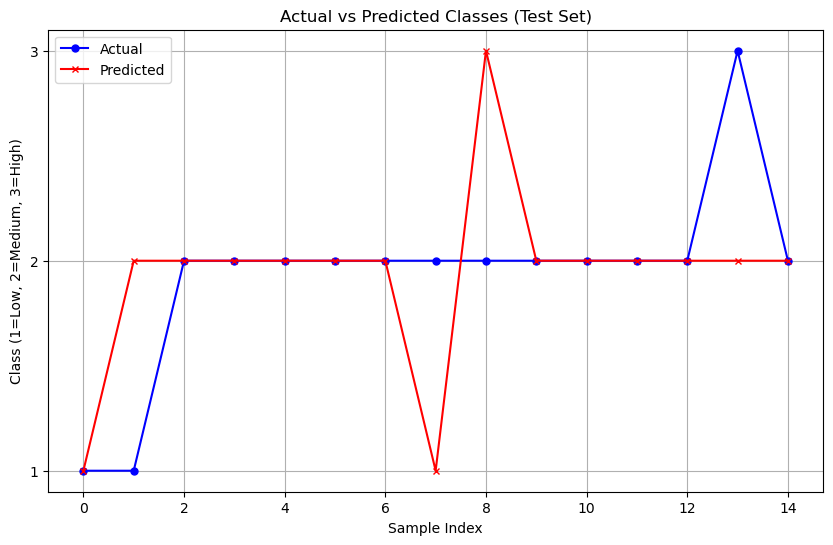

In [89]:
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(y_test.reset_index(drop=True), label='Actual', color='blue', marker='o', linestyle='-', markersize=5)

# Plot the predicted values
plt.plot(y_pred_test_bal, label='Predicted', color='red', marker='x', linestyle='-', markersize=5)

plt.title('Actual vs Predicted Classes (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Class (1=Low, 2=Medium, 3=High)')
plt.yticks([1, 2, 3])
plt.legend()
plt.grid(True)
plt.show()

##### RandomOverSampler

In [90]:
# Define the features and target
X = vi_team[['topic_4', 'topic_0', 'topic_1', 'topic_2', 'team_lexical_diversity']]
y = vi_team['avg_outcome_score'].astype(int)  # convert to int 

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Before oversampling
print("Original class distribution:", Counter(y_train))

# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Random over sampling
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# After oversampling
print("Balanced class distribution:", Counter(y_train_bal))

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)


rf = AdaBoostRegressor(
    estimator=RandomForestClassifier(
    n_estimators=1000,
    max_depth=5, 
    class_weight='balanced',  # <- THIS
    random_state=42
), 
    n_estimators=2000, random_state=13
)


# Train classifier
# rf = RandomForestClassifier(
#     n_estimators=100,
#     max_depth=5, 
#     class_weight='balanced',  # <- THIS
#     random_state=42
# )
# rf.fit(X_train_scaled, y_train)  # Use original y_train without resampling

rf_bal.fit(X_train_scaled, y_train_bal)

# Predict
y_pred_train_bal = rf_bal.predict(X_train_scaled)
y_pred_test_bal = rf_bal.predict(X_test_scaled)

# Evaluation
print("Train Report:\n", classification_report(y_train_bal, y_pred_train_bal))
print("Test Report:\n", classification_report(y_test, y_pred_test_bal))


Original class distribution: Counter({4: 26, 3: 18, 2: 9, 5: 5, 6: 2})
Balanced class distribution: Counter({4: 26, 2: 26, 3: 26, 5: 26, 6: 26})
Train Report:
               precision    recall  f1-score   support

           2       0.96      1.00      0.98        26
           3       1.00      0.92      0.96        26
           4       0.96      0.96      0.96        26
           5       0.96      1.00      0.98        26
           6       1.00      1.00      1.00        26

    accuracy                           0.98       130
   macro avg       0.98      0.98      0.98       130
weighted avg       0.98      0.98      0.98       130

Test Report:
               precision    recall  f1-score   support

           2       0.33      0.50      0.40         2
           3       0.75      0.75      0.75         4
           4       0.50      0.25      0.33         8
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

    accurac

In [91]:
print("Train Accuracy:", accuracy_score(y_train_bal, y_pred_train_bal))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test_bal))
print("Train Macro F1:", f1_score(y_train_bal, y_pred_train_bal, average='macro'))
print("Test Macro F1:", f1_score(y_test, y_pred_test_bal, average='macro'))


Train Accuracy: 0.9769230769230769
Test Accuracy: 0.4
Train Macro F1: 0.9767605224963715
Test Macro F1: 0.29666666666666663


In [92]:
# 1. Define features and target
X = vi_team[['message_length_category_short','m_making_design_choices','wordCount','message_length_category_medium','mentor_player_chat_ratio']]
y = vi_team['avg_outcome_score']  # true labels 2–6 preserved

# 2. Scale features (optional but recommended)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Initialize model with class_weight
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',  # Pay more attention to underrepresented classes
    random_state=42
)

# 4. Stratified K-Fold Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = cross_val_score(rf, X_scaled, y, cv=skf, scoring='f1_macro')
acc_scores = cross_val_score(rf, X_scaled, y, cv=skf, scoring='accuracy')

print("Average CV Accuracy: {:.3f}".format(acc_scores.mean()))
print("Average CV Macro F1 Score: {:.3f}".format(f1_scores.mean()))

Average CV Accuracy: 0.347
Average CV Macro F1 Score: 0.180


- Plot

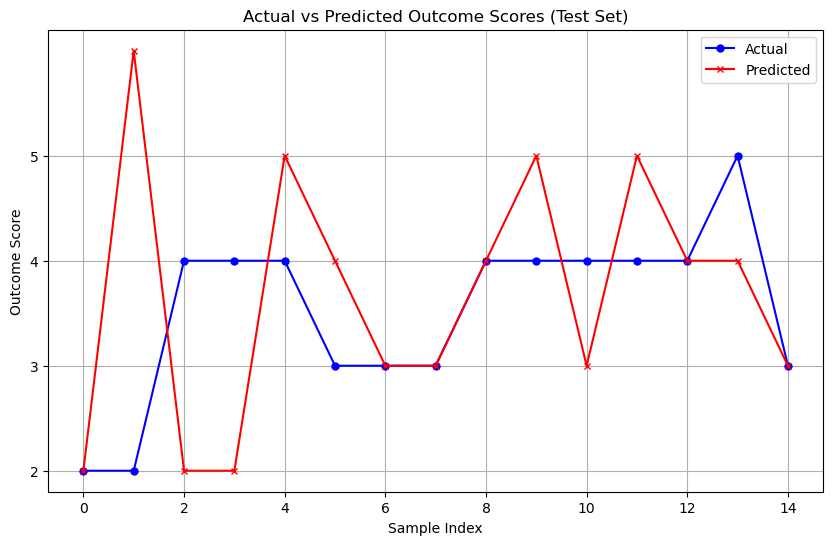

In [93]:
# Reset index for alignment
y_test_reset = y_test.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred_test_bal).reset_index(drop=True)

plt.figure(figsize=(10, 6))

# Plot actual scores
plt.plot(y_test_reset, label='Actual', color='blue', marker='o', linestyle='-', markersize=5)

# Plot predicted scores
plt.plot(y_pred_reset, label='Predicted', color='red', marker='x', linestyle='-', markersize=5)

plt.title('Actual vs Predicted Outcome Scores (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Outcome Score')
plt.yticks(sorted(y_test.unique()))  # show actual classes on y-axis
plt.legend()
plt.grid(True)
plt.show()


- Generally, class balancing techniques helps in a very limited way
  - `SMOTE` works wells with a high training and testing accuracy score 
     - However, it works well due to 'bucketing' where outcome scored is **balanced** to only 3 categories: low, medium, high
     - We can't predict the **exact** outcome score
  - `RandomOVerSampler` gives almost same result as the `baseline models`

  <hr>

### EDA (UPDATED - 29 features)

this section is under EDA, <b>after text EDA</b>

pls refer to report doc for proper analysis

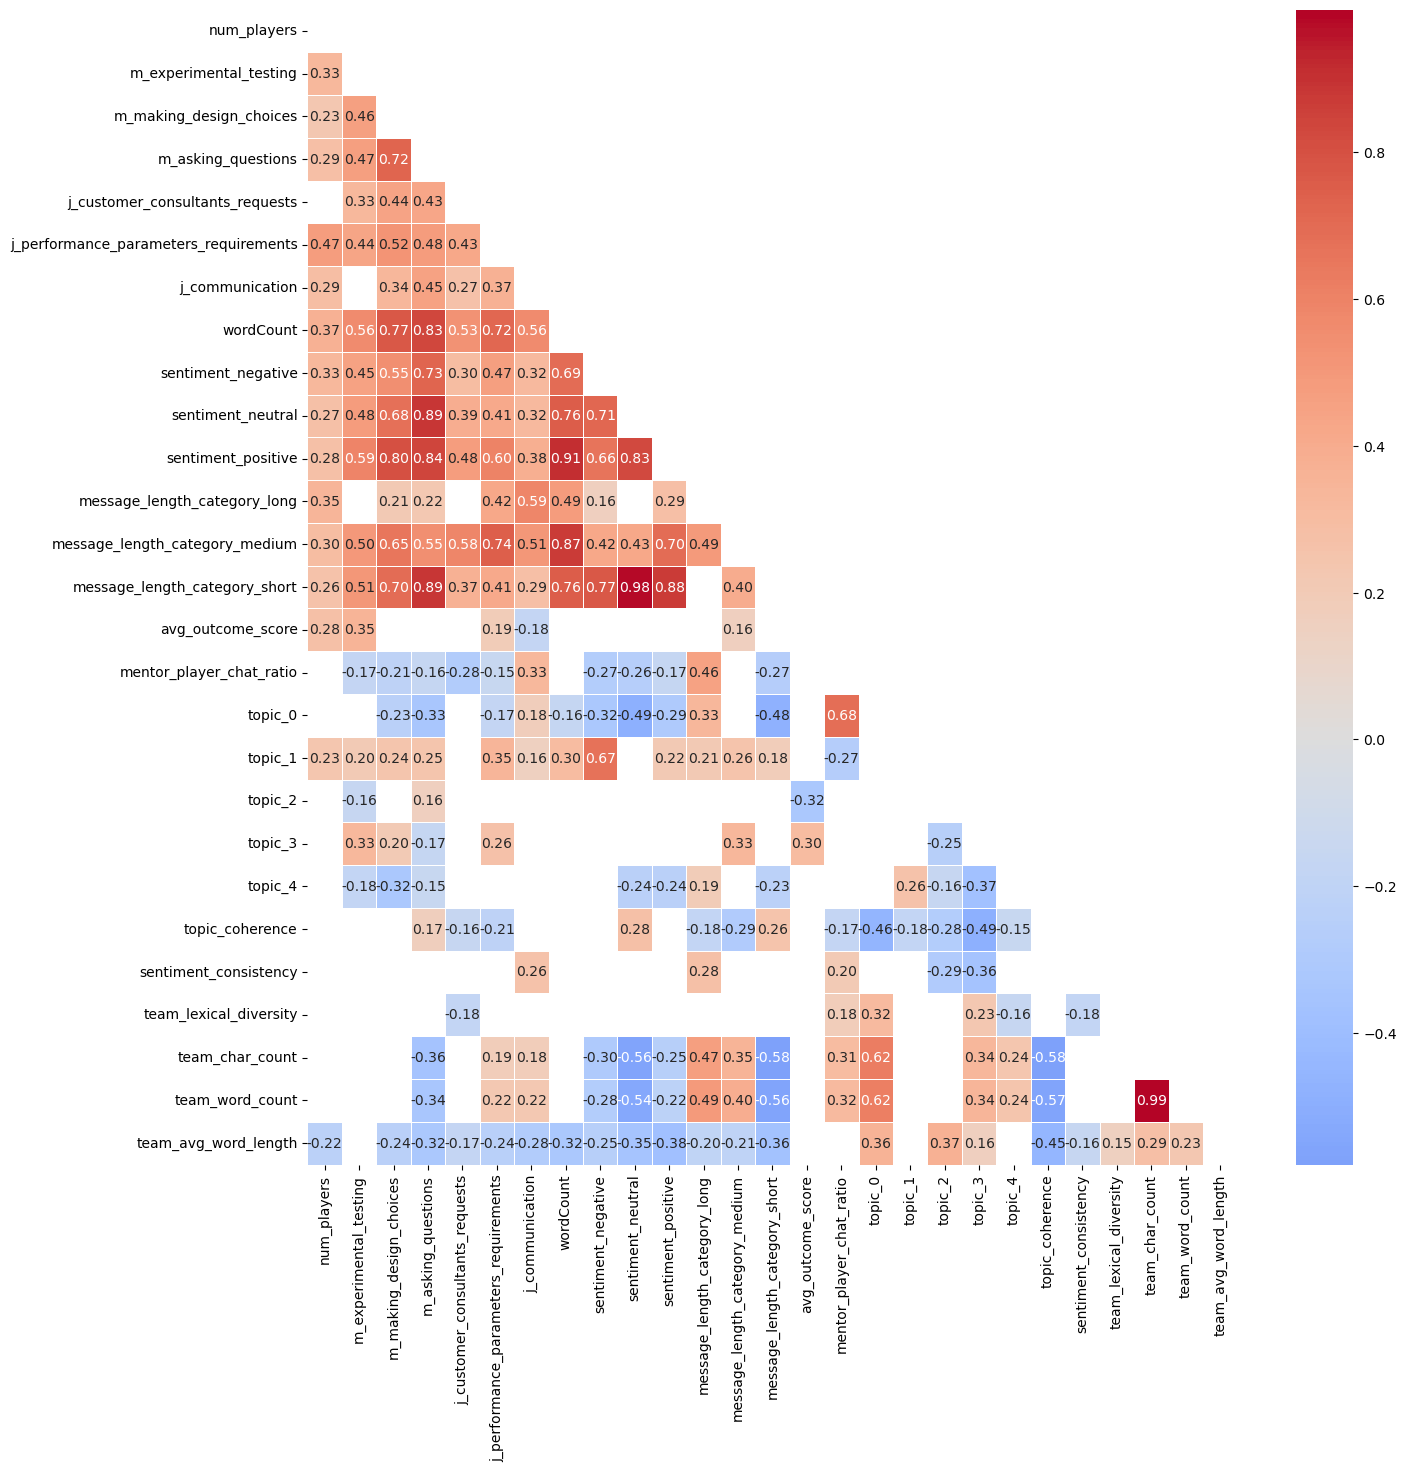

In [55]:
def plot_corrs_big(df, threshold):
    corrs = df.corr()
    filtered_corrs = corrs.where(np.abs(corrs) >= threshold)
    mask = np.triu(np.ones_like(filtered_corrs, dtype=bool))
    plt.figure(figsize=(15,15))
    sns.heatmap(filtered_corrs, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5, cbar=True, mask=mask);

vi_team_cont = vi_team.drop(columns=['implementation', 'ChatGroup'])
plot_corrs_big(vi_team_cont, 0.15)

<b>kde plots of engineered features with target that have abs corrs > 0.15</b>

<Axes: xlabel='message_length_category_medium', ylabel='Density'>

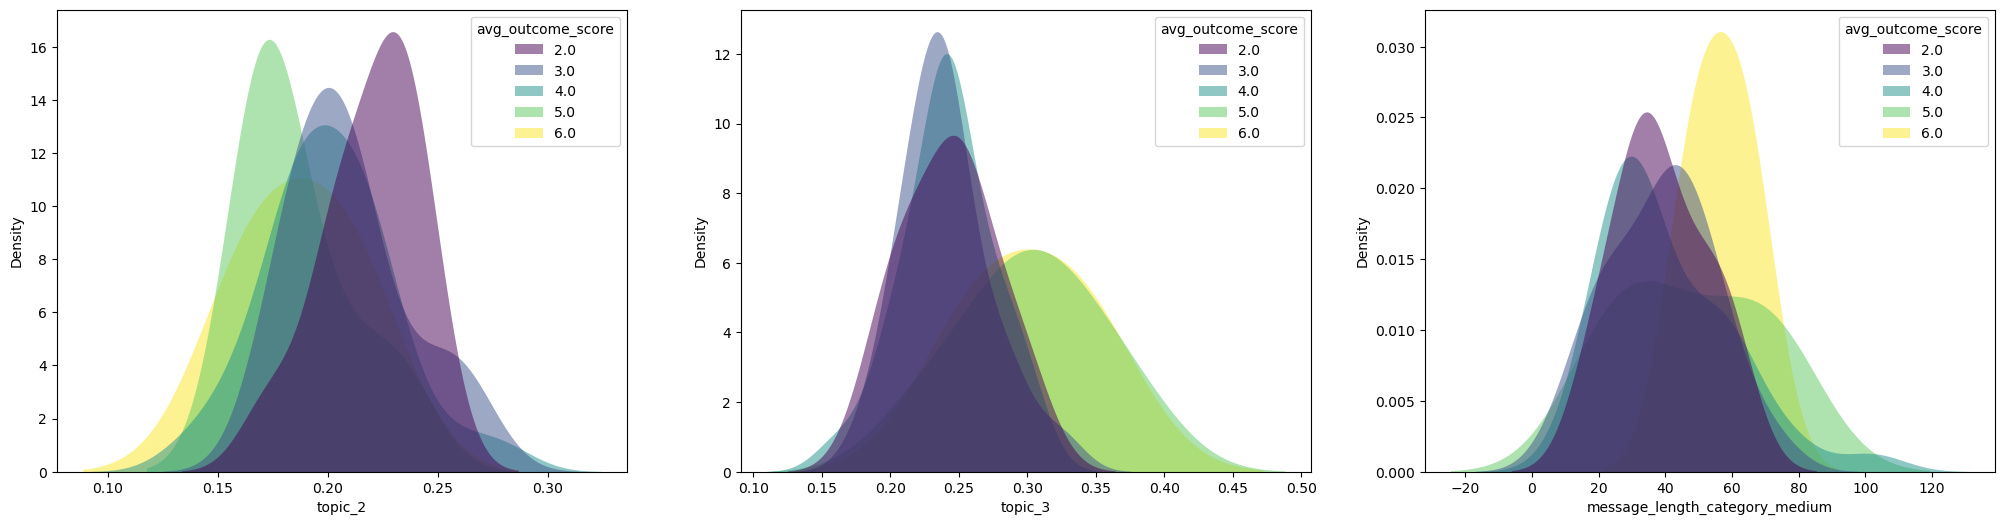

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

sns.kdeplot(ax=axes[0], data=vi_team, x='topic_2', hue='avg_outcome_score', fill=True, common_norm=False, palette="viridis", alpha=.5, linewidth=0)
sns.kdeplot(ax=axes[1], data=vi_team, x='topic_3', hue='avg_outcome_score', fill=True, common_norm=False, palette="viridis", alpha=.5, linewidth=0)
sns.kdeplot(ax=axes[2], data=vi_team, x='message_length_category_medium', hue='avg_outcome_score', fill=True, common_norm=False, palette="viridis", alpha=.5, linewidth=0)

sns.kdeplot(ax=axes[2], data=vi_team, x='mentor_player_chat_ratio', hue='avg_outcome_score', fill=True, common_norm=False, palette="viridis", alpha=.5, linewidth=0)

<b>boxplots of original features with target</b>

used boxplots because alot overlap/not much corrs so boxplot easier to visualise distributions across scores

<Axes: xlabel='avg_outcome_score', ylabel='j_communication'>

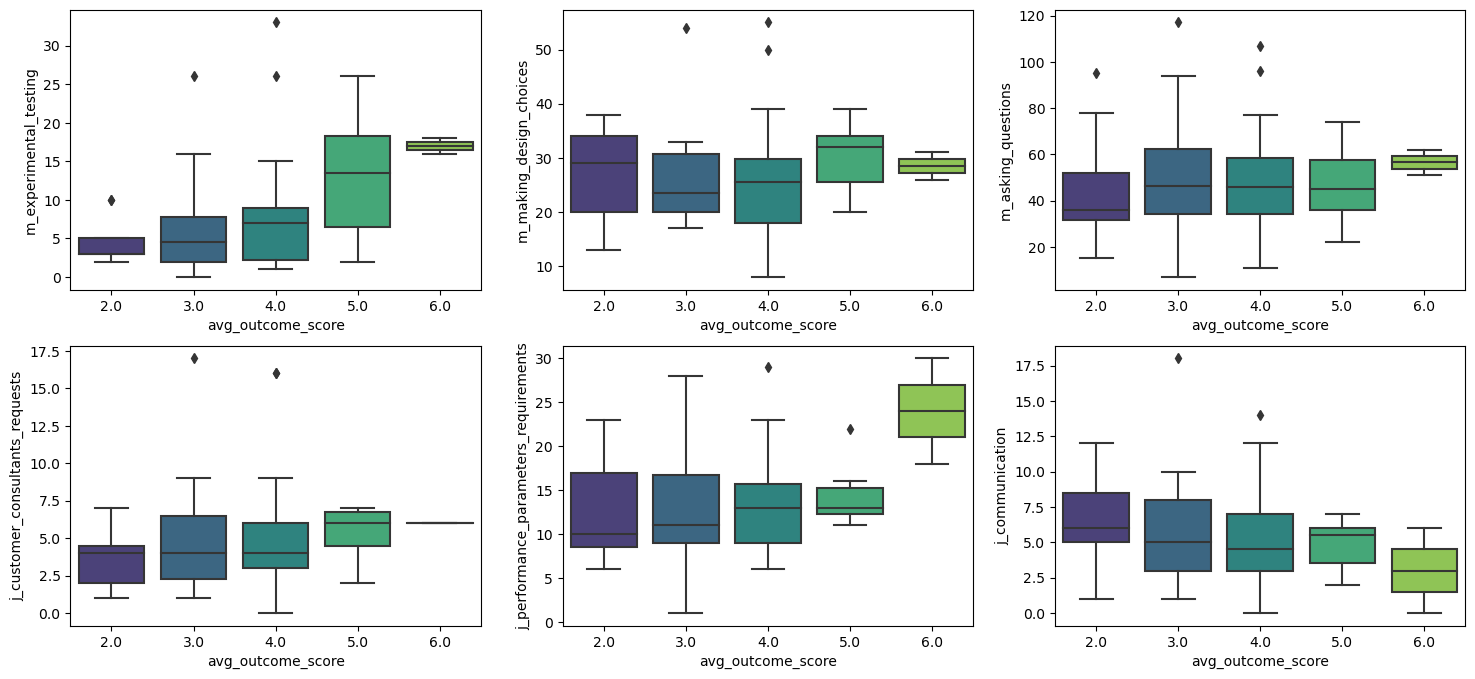

In [91]:
fig, axes = plt.subplots(2, 3, figsize=(18,8))

sns.boxplot(ax=axes[0,0], data=vi_team, x='avg_outcome_score', y='m_experimental_testing', palette='viridis')
sns.boxplot(ax=axes[0,1], data=vi_team, x='avg_outcome_score', y='m_making_design_choices', palette='viridis')
sns.boxplot(ax=axes[0,2], data=vi_team, x='avg_outcome_score', y='m_asking_questions', palette='viridis')

sns.boxplot(ax=axes[1,0], data=vi_team, x='avg_outcome_score', y='j_customer_consultants_requests', palette='viridis')
sns.boxplot(ax=axes[1,1], data=vi_team, x='avg_outcome_score', y='j_performance_parameters_requirements', palette='viridis')
sns.boxplot(ax=axes[1,2], data=vi_team, x='avg_outcome_score', y='j_communication', palette='viridis')


<b>boxplots for influence of mentor and number of players in team</b>

<Axes: xlabel='avg_outcome_score', ylabel='num_players'>

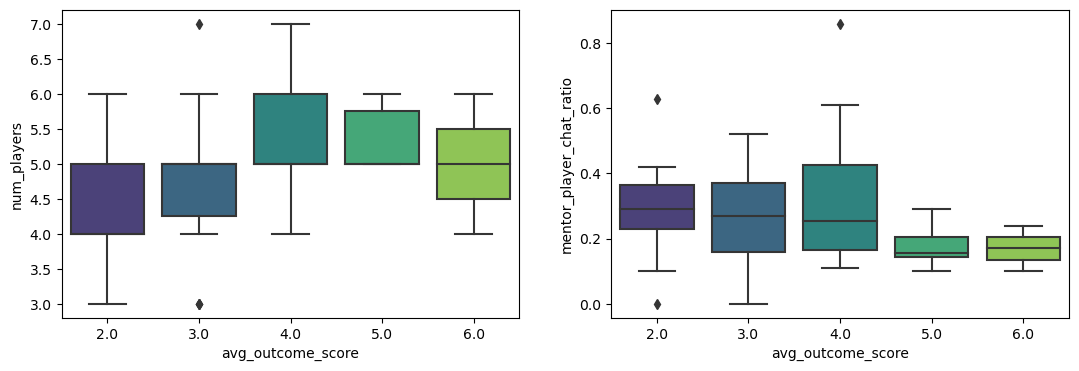

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))

sns.boxplot(ax=axes[1], data=vi_team, y='mentor_player_chat_ratio', x='avg_outcome_score', palette='viridis')
sns.boxplot(ax=axes[0], data=vi_team, y='num_players', x='avg_outcome_score', palette='viridis')

from the plots, on average:
- positively correlated: `m_experimental_testing`
- inversely correlated: `j_communication`, `mentor_player_chat_ratio`
- `j_performance_parameters_requirements` : only score 6 is >20
- `num_players` does not seem to have clear effect despite the 0.28 corr score

all the patterns not very obvious/some places quite ambiguous though.

<hr>